# Inference of $\kappa$ Distributions

## Purpose
This notebook gathers every post-processing step used in the anisotropy study. It ingests the consolidated simulation outputs stored in `simulations_paper.csv`, recreates the main exploratory checks, and generates the publication-ready figures referenced in the paper.

## Workflow
1. **Load simulation runs** collected in `results/` and merge them into a single `pandas.DataFrame`.
2. **Filter the design grid** (true $\kappa$, level $u$, sample size, etc.) to focus on the scenarios described in the manuscript.
3. **Define the theoretical functions** used by the Contour (Cabana) and LKC estimators as well as their numerical inverses.
4. **Visualise estimator behaviour** through marginal densities, joint scatter plots, and squared-error diagnostics stratified by $u$ and true $\kappa$.
5. **Report statistical power** curves contrasting the contour-based and LKC-based procedures under $\mathbb{H}_0$ vs $\mathbb{H}_1$.

Every plot can be regenerated locally by re-running the notebook after placing the simulation CSV files under `results/`. The figures save deterministically once `save_figs` is enabled.

## Simulation Parameters
Each row in `simulations_paper.csv` contains the metadata listed below.
- `kappa`: target anisotropy strength (0 isotropic, 1 highly anisotropic).
- `a_parameter`: $(1-\kappa^2)^{-1/4}$, controlling the covariance stretch.
- `field_size`: number of pixels along one axis (denoted $s$).
- `unit_length`: pixel-to-physical scaling; `T_parameter = field_size / unit_length`.
- `gstools_model_rescale_factor`, `gstools_model_len_scale`, `gstools_model_anis_ratio`: parameters passed to `gstools` to simulate elliptical fields.
- `angle_rad` ($\theta$): true orientation of the anisotropy axis.
- `level_val` ($u$): threshold defining the excursion set.
- `total_points_generated` ($m$): number of points obtained along the level sets.
- Estimators such as `estimated_kappa_cabana`, `estimated_kappa_BD`, and gradient-based surrogates.
- Geometric summaries (`perimeter`, `volume_sublevel_set`, Euler characteristics) and auxiliary statistics (e.g., `chi2_pvalue`).

Refer to `simulations_paper.ipynb` for details about how these quantities are produced.

In [1]:
# coding: utf-8
# Helper utilities for loading simulation CSV files and configuring the plotting style.
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.stats import norm
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# Apply a consistent publication style to every figure.
sns.set_theme(context='paper', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style() 
dpi = 200  # Output resolution expressed in dots per inch.
figsize = (4, 3)  # Default (width, height) of generated figures in inches.

# Root folder storing the CSV exports generated by simulations_paper.ipynb.
folder_path = 'results/'

# Collect cleaned DataFrames before concatenation.
dataframes = []

# Recursively scan the folder tree and load CSV files that contain the chi-square diagnostics.
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            # Retain only files exposing the chi-square statistics consumed later in this notebook.
            if all(col in df.columns for col in ['factor_divide', 'chi2_pvalue', 'total_points_generated', 'kappa', 'T_parameter', 'level_val', 'unit_length']):
                df_plot = df.dropna(subset=['chi2_pvalue'])
                if 'T_parameter' in df_plot.columns:
                    df_plot = df_plot[df_plot['T_parameter'] == 200]
                    df_plot = df_plot[df_plot['unit_length'] == 5]
                # Enforce batches of 100 rows so that each file maps to a full simulation batch.
                if df_plot.shape[0] % 100 != 0:
                    print(f"File {file} has {df.shape[0]} rows, which is NOT a multiple of 100. Skipping this file.")
                    continue
                else:
                    print(f"File {file} has {df.shape[0]} rows, which is a multiple of 100. Including in final DataFrame.")
                    dataframes.append(df_plot)

# Combine the retained files into the working DataFrame.
all_df = pd.concat(dataframes, ignore_index=False)
all_df.head()
print(f"Number of rows: {all_df.shape[0]}, Number of columns: {all_df.shape[1]}")
print(f"Columns: {all_df.columns.tolist()}")

def elliptic_cabana(kappa_var):
    """Compute the Cabana contour functional g(kappa)=∫(2cos²θ−1)(…) / ∫(…) for kappa∈[0,1)."""
    # Numerator integrand (2cos^2θ - 1) * (1 - kappa^2 cos^2θ)^(-3/2)
    def numerator_integrand(theta):
        cos_theta_sq = np.cos(theta)**2
        return (2 * cos_theta_sq - 1) * (1 - (kappa_var**2) * cos_theta_sq)**(-3/2)

    # Denominator integrand (1 - kappa^2 cos^2θ)^(-3/2)
    def denominator_integrand(theta):
        cos_theta_sq = np.cos(theta)**2
        return (1 - (kappa_var**2) * cos_theta_sq)**(-3/2)

    lower_limit = 0
    upper_limit = np.pi / 2

    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", UserWarning)
            integral_numerator, err_num = quad(numerator_integrand, lower_limit, upper_limit, epsrel=1e-12, epsabs=1e-12)
            if w and issubclass(w[-1].category, UserWarning):
                err_num_msg = str(w[-1].message)
    except Exception as e:
        err_num_msg = str(e)
        integral_numerator = np.nan

    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", UserWarning)
            integral_denominator, err_den = quad(denominator_integrand, lower_limit, upper_limit, epsrel=1e-12, epsabs=1e-12)
            if w and issubclass(w[-1].category, UserWarning):
                err_den_msg = str(w[-1].message)
    except Exception as e:
        err_den_msg = str(e)
        integral_denominator = np.nan

    if np.isinf(integral_numerator) or np.isinf(integral_denominator) or \
       np.isnan(integral_numerator) or np.isnan(integral_denominator) or \
       abs(integral_denominator) < 1e-12:
        return np.nan

    return integral_numerator / integral_denominator

def elliptic_bierme_desolneux(kappa_var):
    """Compute the Bierme–Desolneux functional R(kappa)=sqrt(1-kappa²)/[∫sqrt(1-kappa²sin²θ)dθ]^2 for kappa∈[0,1)."""
    def denominator_integrand(theta):
        sin_theta_sq = np.sin(theta)**2
        return np.sqrt(1 - (kappa_var**2) * sin_theta_sq)

    lower_limit = 0
    upper_limit = np.pi / 2

    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", UserWarning)
            integral_denominator, err_den = quad(denominator_integrand, lower_limit, upper_limit, epsrel=1e-12, epsabs=1e-12)
            if w and issubclass(w[-1].category, UserWarning):
                err_den_msg = str(w[-1].message)
    except Exception as e:
        err_den_msg = str(e)
        integral_denominator = np.nan

    if abs(integral_denominator) < 1e-12:
        return np.nan
        
    return np.sqrt(1 - (kappa_var**2)) / (integral_denominator**2)

File simulation_results_20250923072221.csv has 800 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20251106154829.csv has 300 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20250624062234.csv has 300 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20250920111214.csv has 500 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20250622164720.csv has 1000 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20250920071732.csv has 1000 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20251006063009.csv has 1000 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20251104161828.csv has 300 rows, which is a multiple of 100. Including in final DataFrame.
File simulation_results_20251002230308.csv has 1000 rows, which is a multiple

In [2]:
kappa_aimed = [0, 0.5, 0.9]

kappa_targets = np.sort(all_df['kappa'].unique())
print("Values of kappa_targets:", kappa_targets)

# Limit the analysis to kappas that are actually present in the merged dataset.
kappa_aimed = [k for k in kappa_aimed if k in kappa_targets]
print("Values of kappa_aimed:", kappa_aimed)
# Drop all other kappas so the remainder matches the manuscript scenarios.
all_df = all_df[all_df['kappa'].isin(kappa_aimed)]
# print(f"Number of rows: {all_df.shape[0]}, Number of columns: {all_df.shape[1]}")

total_points_generated_aimed = [int(1e7)]
total_points_generated_targets = np.sort(all_df['total_points_generated'].unique())
print("Values of total_points_generated_targets:", total_points_generated_targets)
# Keep only the Monte Carlo batches that produced 1e7 contour points.
total_points_generated_aimed = [tp for tp in total_points_generated_aimed if tp in total_points_generated_targets]
print("Values of total_points_generated_aimed:", total_points_generated_aimed)
# Exclude rows with other sample sizes.
all_df = all_df[all_df['total_points_generated'].isin(total_points_generated_aimed)]

factor_divide_aimed = [10, 25]
factor_divide_targets = np.sort(all_df['factor_divide'].unique())
print("Values of factor_divide_targets are:", factor_divide_targets)
# Retain only the decimation factors that appear in the manuscript tables.
factor_divide_aimed = [fd for fd in factor_divide_aimed if fd in factor_divide_targets]
print("Values of factor_divide_aimed are Nan and:", factor_divide_aimed)
# Also retain NaN entries (no decimation applied).
all_df = all_df[all_df['factor_divide'].isin(factor_divide_aimed) | all_df['factor_divide'].isna()]

T_aimed = [200]
T_targets = np.sort(all_df['T_parameter'].unique())
print("Values of T_targets:", T_targets)
# Keep the observation window size T reported in the paper.
T_aimed = [t for t in T_aimed if t in T_targets]
print("Values of T_aimed:", T_aimed)
# Remove rows outside the retained T grid.
all_df = all_df[all_df['T_parameter'].isin(T_aimed)]  

all_df['estimated_kappa_BD'] = all_df['estimated_kappa_BD'].fillna(0)

level_targets = all_df['level_val'].unique()
print("Values of level_targets:", level_targets)

field_size_aimed = [1000]
field_size_targets = all_df['field_size'].unique()
print("Values of field_size:", field_size_targets)
field_size_aimed = [fs for fs in field_size_aimed if fs in field_size_targets]
print("Values of field_size_aimed:", field_size_aimed)
all_df = all_df[all_df['field_size'].isin(field_size_aimed)]    

total_points_generated_targets = all_df['total_points_generated'].unique()
print("Values of total_points_generated:", total_points_generated_targets)


print(f"Number of rows: {all_df.shape[0]}, Number of columns: {all_df.shape[1]}")
output_path = "simulations_paper.csv"
all_df.to_csv(output_path, index=False)
print(f"Saved filtered DataFrame to {output_path} with shape {all_df.shape}.")

threshold_data_points = 300

Values of kappa_targets: [0.  0.5 0.8 0.9]
Values of kappa_aimed: [0, 0.5, 0.9]
Values of total_points_generated_targets: [10000000]
Values of total_points_generated_aimed: [10000000]
Values of factor_divide_targets are: [10 25]
Values of factor_divide_aimed are Nan and: [10, 25]
Values of T_targets: [200.]
Values of T_aimed: [200]
Values of level_targets: [0 1 2]
Values of field_size: [1000]
Values of field_size_aimed: [1000]
Values of total_points_generated: [10000000]
Number of rows: 40800, Number of columns: 42
Saved filtered DataFrame to simulations_paper.csv with shape (40800, 42).


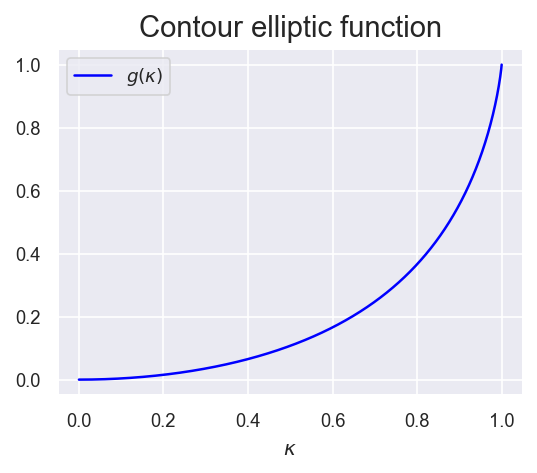

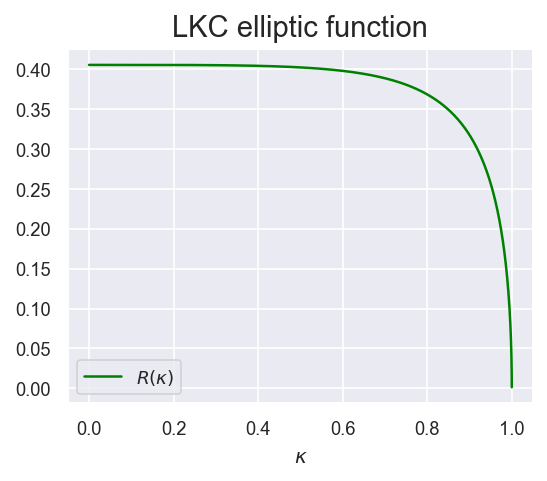

In [3]:
# Sweep a dense grid of κ values to trace the theoretical contour and LKC curves.
kappa_values = np.linspace(0, 1-1e-6, 5000)

# Evaluate the Cabana functional g(κ) across the grid for later reference lines.
elliptic_cabana_values = [elliptic_cabana(kappa) for kappa in kappa_values]

# Visualise g(κ) to verify numerical stability over κ ∈ [0,1).
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(kappa_values, elliptic_cabana_values, label='$g(\\kappa)$', color='blue')
plt.title('Contour elliptic function', fontsize=14)
plt.xlabel('$\\kappa$')
#plt.ylabel('$g(\\kappa)$')
plt.grid(True)
plt.legend()
plt.show()

# Evaluate the Biermé–Desolneux functional R(κ) used by the LKC estimator.
elliptic_bierme_desolneux_values = [elliptic_bierme_desolneux(kappa) for kappa in kappa_values]

# Plot R(κ) to confirm the monotonic behaviour assumed by downstream inversions.
plt.figure(figsize=(4, 3.07), dpi=150)
plt.plot(kappa_values, elliptic_bierme_desolneux_values, label='$R(\\kappa)$', color='green')
plt.title('LKC elliptic function', fontsize=14)
plt.xlabel('$\\kappa$')
#plt.ylabel('$R(\\kappa)$')
plt.grid(True)
plt.legend()
plt.show()

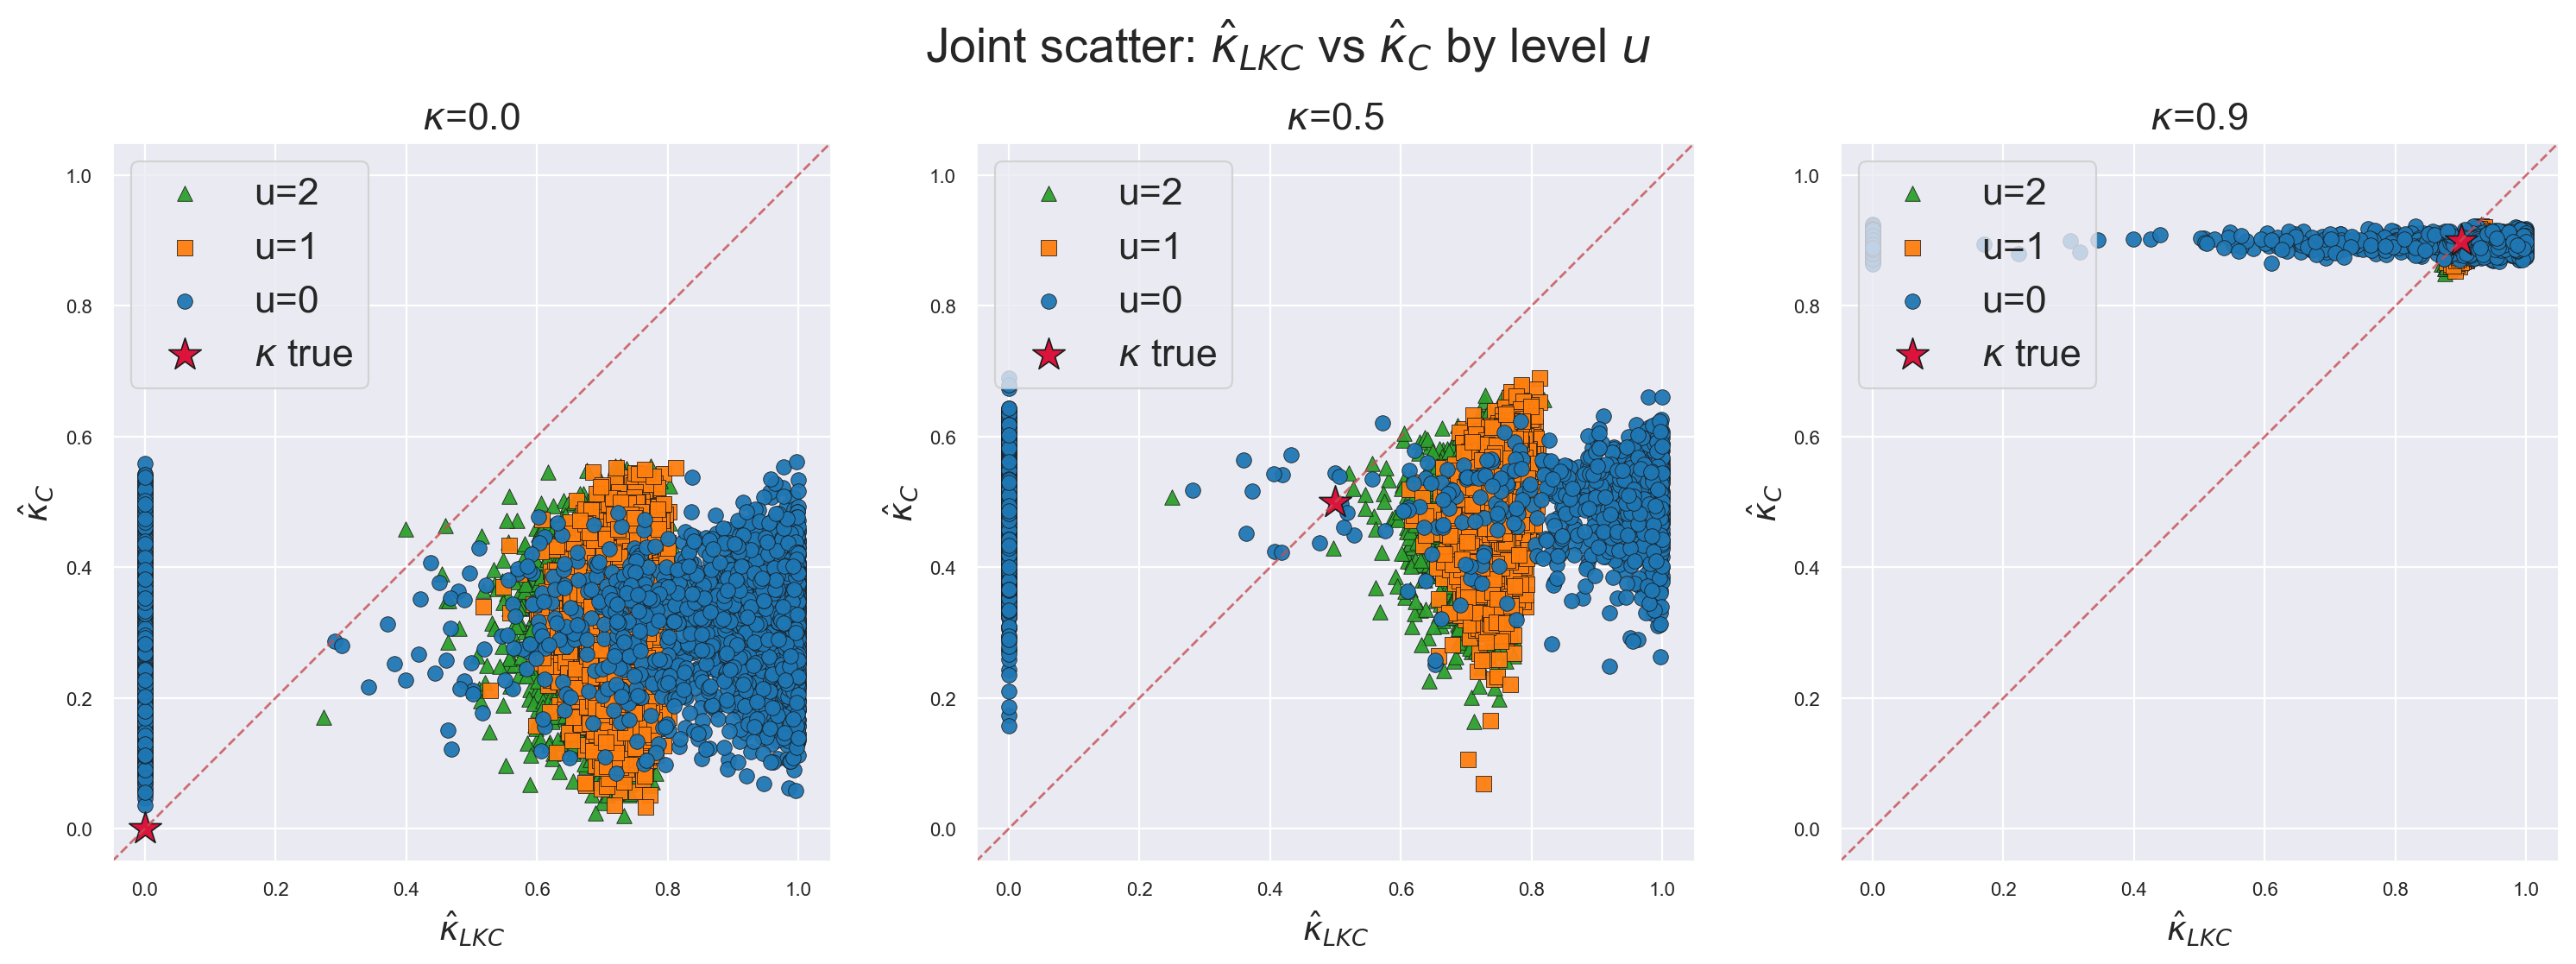

In [4]:
# Joint scatter diagnostics: each subplot fixes κ and overlays the three excursion levels (u = 0, 1, 2).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# coding: utf-8
fontsize_legend = 16
fontsize_title = 16
fontsize_suptitle = 20
fontsize_labels = 14
fontsize_ticks = 8
size_scatter = 40
size_scatter_edge = 0.3
alpha_scatter = 0.95
size_scatter_star = 200
linewidths_scatter_star = 0.6
linewidths_scatter = 0.3
dpi = 200

# Guard clause: stop early if the Cabana and BD estimators are missing.
req_cols = ['kappa', 'level_val', 'estimated_kappa_BD', 'estimated_kappa_cabana']
missing = [c for c in req_cols if c not in all_df.columns]
if missing:
    print(f"Error: missing columns in all_df: {missing}")
else:
    # Adopt BD on the x-axis and Cabana on the y-axis for direct estimator comparison.
    x_col = 'estimated_kappa_BD'
    y_col = 'estimated_kappa_cabana'

    # Determine which κ values survived the earlier filtering.
    kappa_values = sorted(all_df['kappa'].dropna().unique())
    if len(kappa_values) == 0:
        print('No kappa values available to plot.')
    else:
        # Consistent palette/markers for excursion levels.
        levels_order = [2, 1, 0]
        palette = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}
        markers = {0: 'o', 1: 's', 2: '^'}

        # Retain only rows with finite estimators and levels in levels_order.
        df_valid = all_df[['kappa', 'level_val', x_col, y_col]].dropna()
        df_valid = df_valid[df_valid['level_val'].isin(levels_order)]
        if df_valid.empty:
            print('No valid rows to plot after filtering for required columns and levels.')
        else:
            # Share identical axis limits across panels for a fair visual comparison.
            data_min = df_valid[[x_col, y_col]].min().min()
            data_max = df_valid[[x_col, y_col]].max().max()
            if np.isfinite(data_min) and np.isfinite(data_max):
                overall_min = min(float(data_min), float(np.min(kappa_values)))
                overall_max = max(float(data_max), float(np.max(kappa_values)))
                if np.isclose(overall_min, overall_max):
                    overall_min -= 0.1 if overall_min == 0 else 0.1 * abs(overall_min)
                    overall_max += 0.1 if overall_max == 0 else 0.1 * abs(overall_max)
                padding = 0.05 * (overall_max - overall_min) if (overall_max - overall_min) > 1e-9 else 0.05
                lims = (overall_min - padding, overall_max + padding)
            else:
                lims = (0.0, 1.0)

            # Layout: one column per κ.
            ncols = len(kappa_values)
            fig, axes = plt.subplots(1, ncols, figsize=(5.0 * ncols, 4.9), constrained_layout=True, dpi=dpi)
            if ncols == 1:
                axes = [axes]

            for ax, kappa_val in zip(axes, kappa_values):
                df_k = df_valid[df_valid['kappa'] == kappa_val]
                levels_present = [u for u in levels_order if u in df_k['level_val'].unique()]
                for u in levels_present:
                    df_ku = df_k[df_k['level_val'] == u]
                    if df_ku.empty:
                        continue
                    sns.scatterplot(
                        data=df_ku,
                        x=x_col,
                        y=y_col,
                        ax=ax,
                        s=size_scatter,
                        color=palette.get(u, 'grey'),
                        alpha=alpha_scatter,
                        edgecolor='k',
                        linewidth=linewidths_scatter,
                        marker=markers.get(u, 'o'),
                        label=f'u={int(u)}'
                    )
                # Overlay the bisector and the true κ reference point for orientation.
                ax.plot([lims[0], lims[1]], [lims[0], lims[1]], 'r--', linewidth=1, alpha=0.8)
                ax.scatter([kappa_val], [kappa_val], marker='*', s=size_scatter_star, color='crimson', edgecolor='k', linewidths=linewidths_scatter_star, label='$\\kappa$ true')

                ax.set_title(f'$\\kappa$={kappa_val:.1f}', fontsize=fontsize_title)
                ax.set_xlabel('$\\hat{\\kappa}_{LKC}$', fontsize=fontsize_labels)
                ax.set_ylabel('$\\hat{\\kappa}_{C}$', fontsize=fontsize_labels)
                ax.set_xlim(lims)
                ax.set_ylim(lims)
                ax.set_aspect('equal', adjustable='box')
                ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
                ax.legend(fontsize=fontsize_legend, loc='upper left')

            fig.suptitle('Joint scatter: $\\hat{\\kappa}_{LKC}$ vs $\\hat{\\kappa}_{C}$ by level $u$', fontsize=fontsize_suptitle, y=1.1)
            plt.show()
            

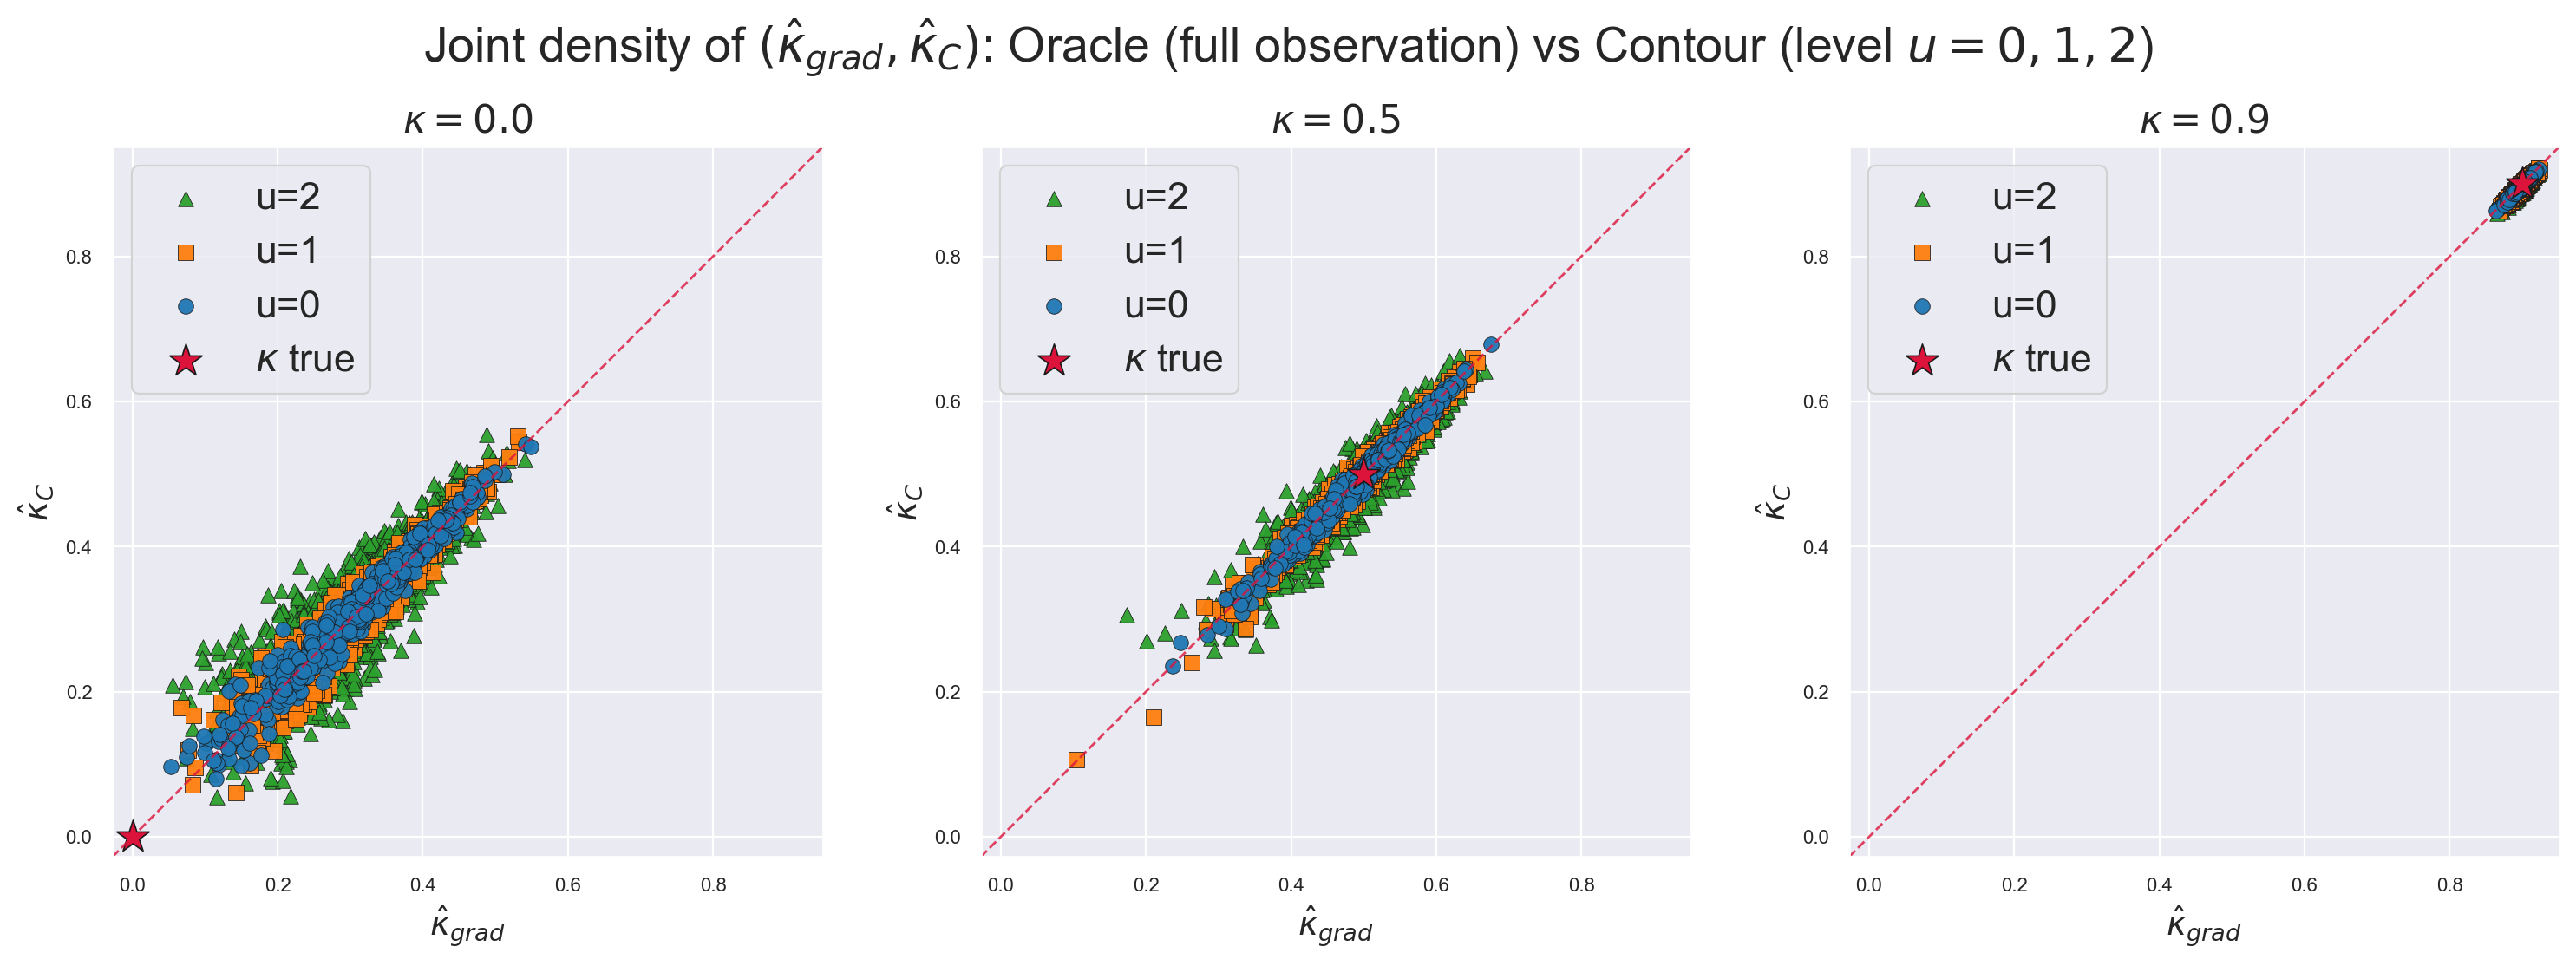

Generated 1×3 joint density figure (kappa_grad vs kappa_C) by true kappa and levels u.


In [5]:
# Joint scatter plots comparing $\hat{\kappa}_{grad}$ (oracle) to $\hat{\kappa}_{C}$ (contour) for each true κ.

# Verify that both estimators are present before constructing the figure.
req_cols = ['kappa', 'level_val', 'estimated_kappa_gradients', 'estimated_kappa_cabana']
missing = [c for c in req_cols if c not in all_df.columns]
if missing:
    print(f"Error: Missing required columns: {missing}")
else:
    # Prefer κ ∈ {0, 0.5, 0.9}; otherwise fall back to however many κ values remain.
    k_in = set(all_df['kappa'].dropna().unique())
    kappas_row = [k for k in [0, 0.5, 0.9] if k in k_in] or sorted(list(k_in))[:3]

    # Build shared axis limits so every subplot is comparable at a glance.
    vals_all = []
    for k in kappas_row:
        sub = all_df[all_df['kappa'] == k]
        for u in [0, 1, 2]:
            d = sub[sub['level_val'] == u][['estimated_kappa_gradients','estimated_kappa_cabana']].dropna()
            if not d.empty:
                vals_all.append(d.to_numpy())
        vals_all.append(np.array([[k, k]]))  # include the κ reference point
    if vals_all:
        arr = np.vstack(vals_all)
        vmin, vmax = float(np.nanmin(arr)), float(np.nanmax(arr))
        pad = max(0.03*(vmax - vmin), 0.02)
        lim_min, lim_max = vmin - pad, vmax + pad
    else:
        lim_min, lim_max = -0.1, 1.1

    level_colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green'}
    level_markers = {0:'o', 1:'s', 2:'^'}

    ncols = len(kappas_row)
    fig, axes = plt.subplots(1, ncols, figsize=(5*ncols, 4.9), dpi=200, constrained_layout=True)
    if ncols == 1:
        axes = np.array([axes])

    for ax, k in zip(axes, kappas_row):
        sub = all_df[all_df['kappa'] == k]
        for u in [2,1,0]:  # reverse order so u=0 (dark) remains visible
            d = sub[sub['level_val'] == u][['estimated_kappa_gradients','estimated_kappa_cabana']].dropna()
            if not d.empty:
                sns.scatterplot(
                        data=d,
                        x='estimated_kappa_gradients',
                        y='estimated_kappa_cabana',
                        ax=ax,
                        s=size_scatter,
                        color=palette.get(u, 'grey'),
                        alpha=alpha_scatter,
                        edgecolor='k',
                        linewidth=linewidths_scatter,
                        marker=markers.get(u, 'o'),
                        label=f'u={int(u)}'
                    )
        # Overlay the bisector and the true κ reference star.
        ax.plot([lim_min, lim_max], [lim_min, lim_max], '--', color='crimson', linewidth=1, alpha=0.8)
        ax.scatter([k], [k], marker='*', s=size_scatter_star, color='crimson', edgecolor='k', linewidths=linewidths_scatter_star, label='$\\kappa$ true')

        ax.set_title(f'$\\kappa={k:.1f}$', fontsize=fontsize_title)
        ax.set_xlabel('$\\hat{\\kappa}_{grad}$', fontsize=fontsize_labels)
        ax.set_ylabel('$\\hat{\\kappa}_{C}$', fontsize=fontsize_labels)
        ax.set_xlim([lim_min, lim_max])
        ax.set_ylim([lim_min, lim_max])
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='upper left', fontsize=fontsize_legend)
        ax.tick_params(axis='both', labelsize=fontsize_ticks)

    fig.suptitle('Joint density of $(\\hat{\\kappa}_{grad},\\hat{\\kappa}_{C})$: Oracle (full observation) vs Contour (level $u=0,1,2$)', y=1.1, fontsize=fontsize_suptitle)
    plt.show()
    print('Generated 1×3 joint density figure (kappa_grad vs kappa_C) by true kappa and levels u.')

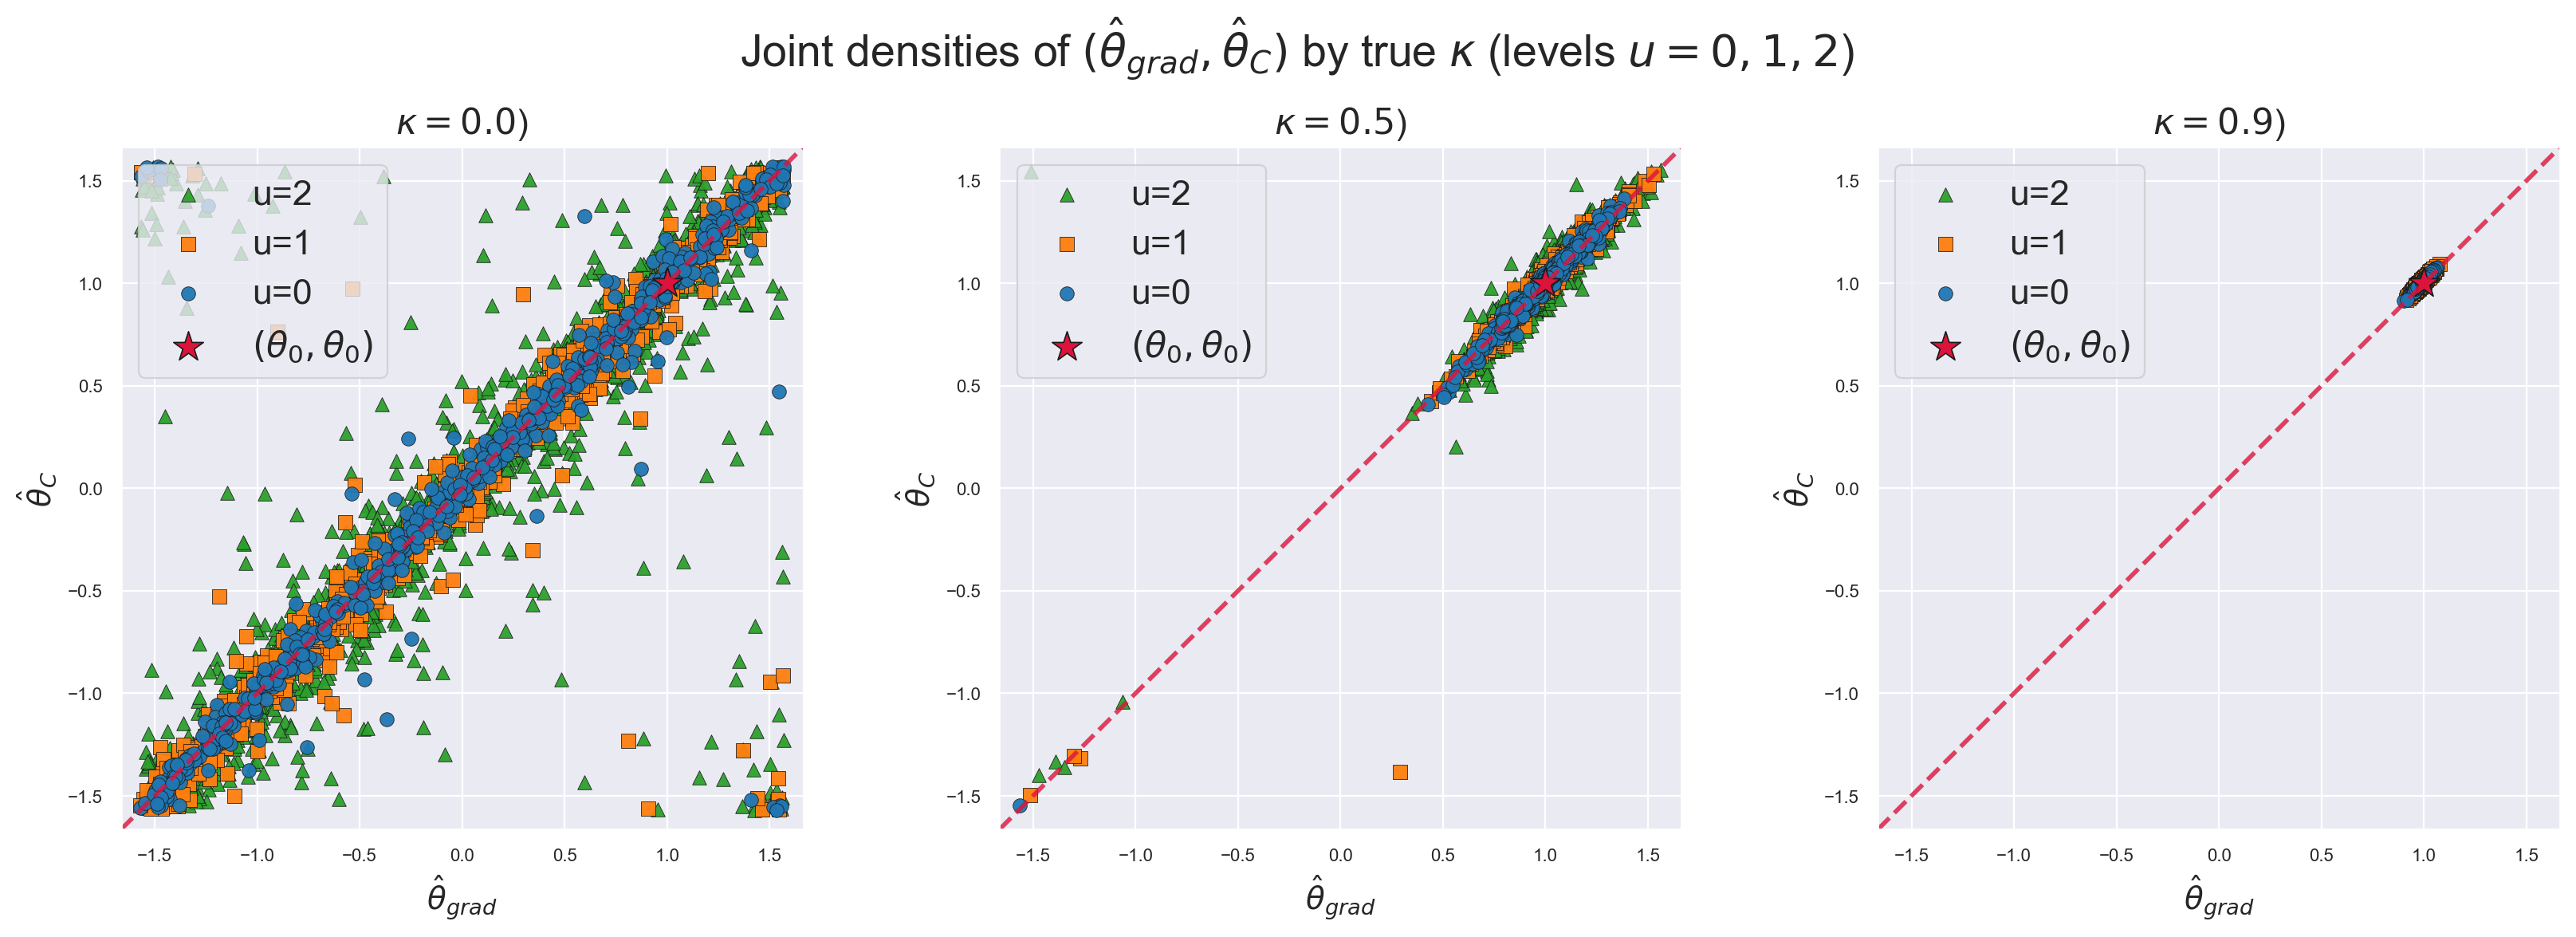

Generated 1×3 joint density figure (theta_grad vs theta_C) by true kappa and level u (raw angles).


In [6]:
# Joint scatter of angle estimators $(\hat{\theta}_{grad}, \hat{\theta}_{C})$ by κ and level $u$.
req_cols = [
    'kappa', 'level_val', 'estimated_angle_gradients',
    'empirical_sine_cabana', 'empirical_cosine_cabana'
]
missing = [c for c in req_cols if c not in all_df.columns]
if missing:
    print(f"Error: Missing required columns for angle joint density: {missing}")
else:
    theta0 = float(globals().get('theta0', 1.0))
    df_angles = all_df.dropna(subset=req_cols).copy()

    if df_angles.empty:
        print('No rows available with complete angle information.')
    else:
        df_angles['theta_grad_hat'] = df_angles['estimated_angle_gradients'].astype(float)
        df_angles['theta_c_hat'] = -0.5 * np.arctan2(
            df_angles['empirical_sine_cabana'].astype(float),
            df_angles['empirical_cosine_cabana'].astype(float)
        )

        kappas_available = sorted(df_angles['kappa'].dropna().unique())
        preferred = [0.0, 0.5, 0.9]
        kappas_row = [k for k in preferred if k in kappas_available] or kappas_available[:3]

        if not kappas_row:
            print('No kappa values available for plotting.')
        else:
            # Aggregate every point first so that axis limits can be shared across κ panels.
            vals_all = []
            for kappa_val in kappas_row:
                sub = df_angles[df_angles['kappa'] == kappa_val]
                for u in [0, 1, 2]:
                    d = sub[sub['level_val'] == u][['theta_grad_hat', 'theta_c_hat']]
                    if not d.empty:
                        vals_all.append(d.to_numpy())
                vals_all.append(np.array([[theta0, theta0]]))
            arr = np.vstack(vals_all)
            vmin, vmax = float(np.nanmin(arr)), float(np.nanmax(arr))
            pad = max(0.03 * (vmax - vmin), 0.02)
            lim_min, lim_max = vmin - pad, vmax + pad

            level_order = [0, 1, 2]
            level_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}
            level_markers = {0: 'o', 1: 's', 2: '^'}

            ncols = len(kappas_row)
            fig, axes = plt.subplots(1, ncols, figsize=(5.5 * ncols, 5.2), dpi=dpi, constrained_layout=True)
            if ncols == 1:
                axes = np.array([axes])

            for ax, kappa_val in zip(axes, kappas_row):
                sub = df_angles[df_angles['kappa'] == kappa_val]
                if sub.empty:
                    ax.text(0.5, 0.5, f'No samples for $\\kappa={kappa_val:.2f}$', transform=ax.transAxes,
                            ha='center', va='center', fontsize=fontsize_labels)
                else:
                    for u in level_order[::-1]:
                        d = sub[sub['level_val'] == u][['theta_grad_hat', 'theta_c_hat']]
                        if d.empty:
                            continue
                        sns.scatterplot(
                            data=d,
                            x='theta_grad_hat',
                            y='theta_c_hat',
                            ax=ax,
                            s=size_scatter,
                            color=level_colors.get(u, 'C0'),
                            alpha=alpha_scatter,
                            edgecolor='k',
                            linewidth=linewidths_scatter,
                            marker=level_markers.get(u, 'o'),
                            label=f'u={int(u)}'
                        )

                # Add the bisector and true orientation star to contextualise deviations.
                ax.plot([lim_min, lim_max], [lim_min, lim_max], '--', color='crimson', linewidth=2, alpha=0.8)
                ax.scatter([theta0], [theta0], marker='*', s=size_scatter_star, color='crimson',
                           edgecolor='k', linewidths=linewidths_scatter_star, label=r'$ (\theta_0, \theta_0)$')
                ax.set_xlim([lim_min, lim_max])
                ax.set_ylim([lim_min, lim_max])
                ax.set_aspect('equal', adjustable='box')
                ax.set_xlabel(r'$\hat{\theta}_{grad}$', fontsize=fontsize_labels)
                ax.set_ylabel(r'$\hat{\theta}_{C}$', fontsize=fontsize_labels)
                ax.set_title(f'$\\kappa={kappa_val:.1f}$)', fontsize=fontsize_title)
                ax.tick_params(axis='both', labelsize=fontsize_ticks)
                ax.legend(loc='upper left', fontsize=fontsize_legend)

            fig.suptitle(r'Joint densities of $(\hat{\theta}_{grad}, \hat{\theta}_{C})$ by true $\kappa$ (levels $u=0,1,2$)',
                         y=1.1, fontsize=fontsize_suptitle)
            plt.show()
            print('Generated 1×3 joint density figure (theta_grad vs theta_C) by true kappa and level u (raw angles).')

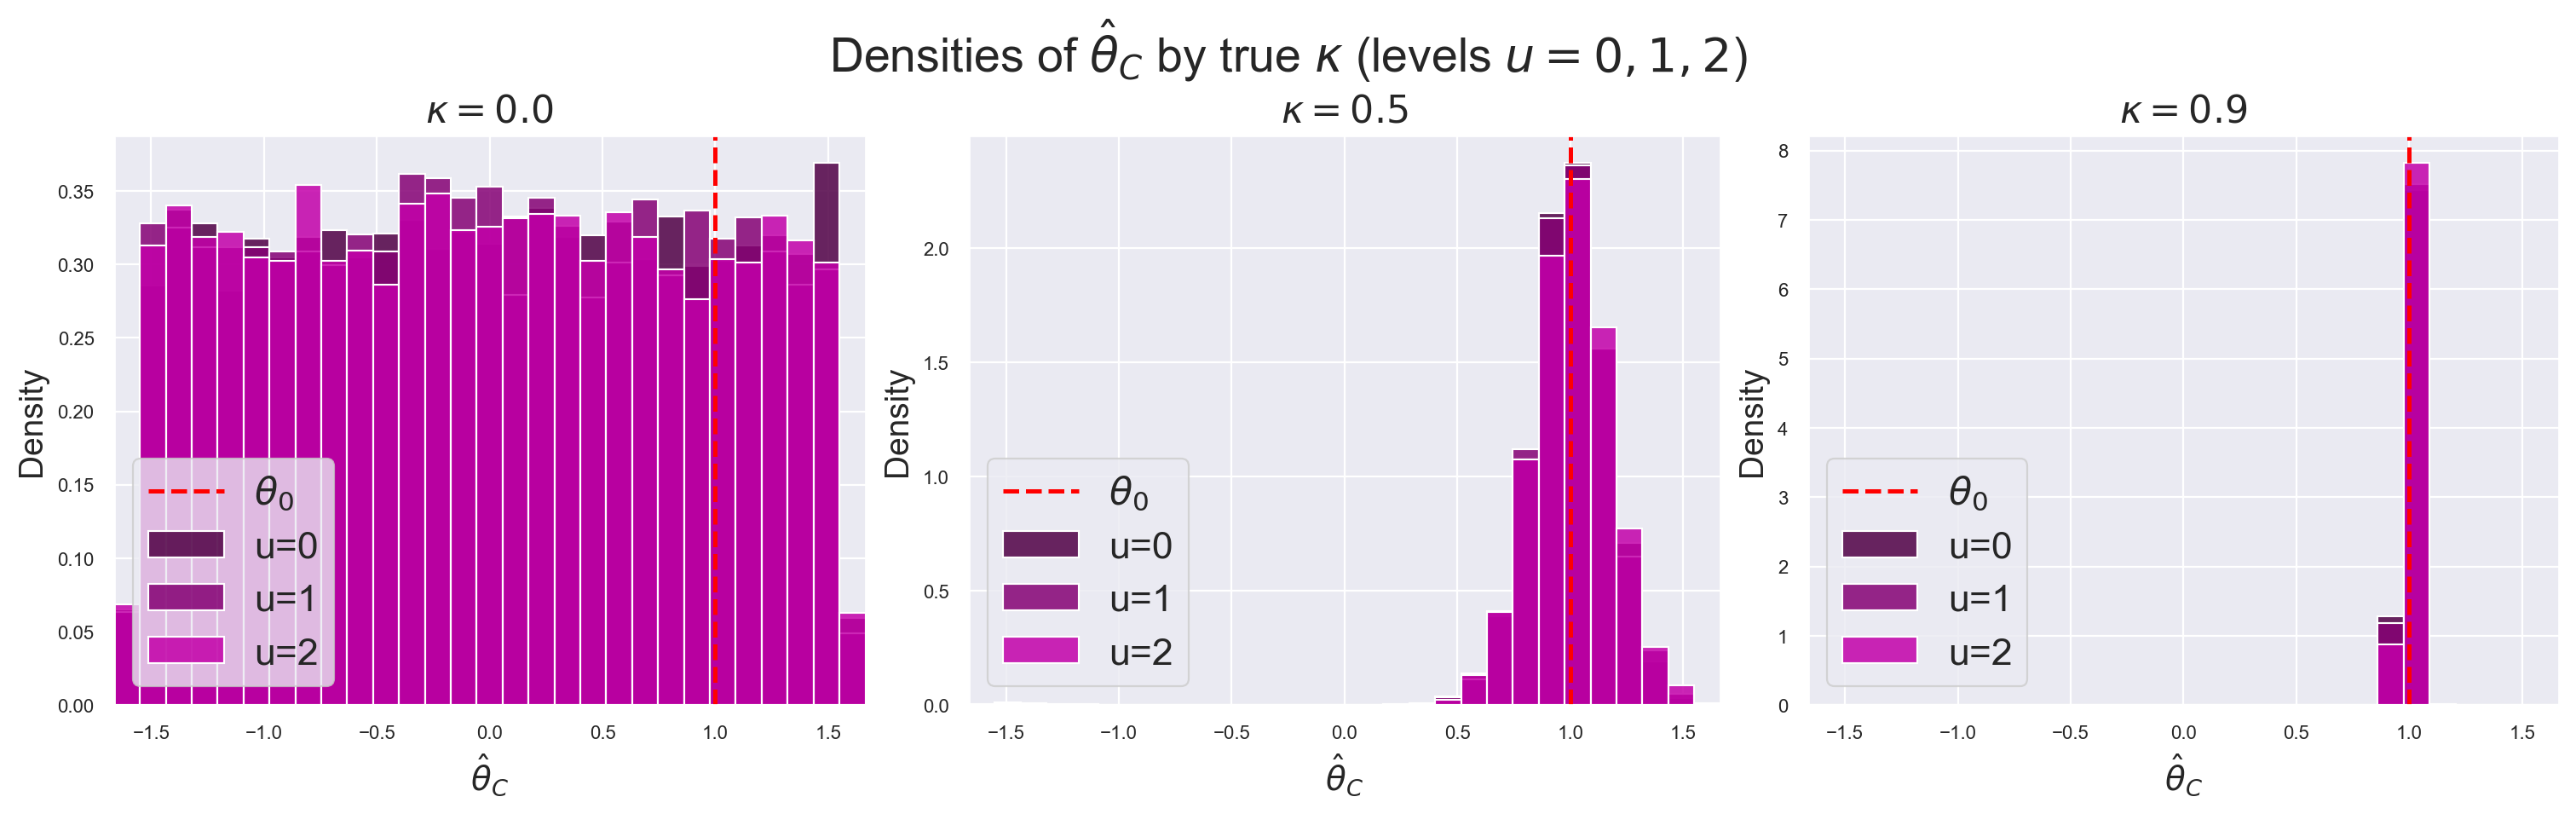

Generated marginal density plots for theta_c_hat by true kappa.


In [7]:
# Marginal densities of $\hat{\theta}_{C}$ across κ (columns) and excursion levels u (colors).
req_cols = ['kappa', 'level_val', 'empirical_sine_cabana', 'empirical_cosine_cabana']
missing = [c for c in req_cols if c not in all_df.columns]
if missing:
    print(f"Error: Missing required columns for theta_C marginals: {missing}")
else:
    theta0 = float(globals().get('theta0', 1.0))
    df_theta = all_df.dropna(subset=req_cols).copy()
    if df_theta.empty:
        print('No rows available with complete Cabana angle data.')
    else:
        df_theta['theta_c_hat'] = -0.5 * np.arctan2(
            df_theta['empirical_sine_cabana'].astype(float),
            df_theta['empirical_cosine_cabana'].astype(float)
        )
        kappas_available = sorted(df_theta['kappa'].dropna().unique())
        preferred = [0.0, 0.5, 0.9]
        kappas_row = [k for k in preferred if k in kappas_available] or kappas_available[:3]
        if not kappas_row:
            print('No kappa values available for plotting theta_c_hat marginals.')
        else:
            # Compute joint x-limits once so that histogram bins are aligned across panels.
            vals_all = []
            for kappa_val in kappas_row:
                sub = df_theta[df_theta['kappa'] == kappa_val]
                for u in [0, 1, 2]:
                    d = sub[sub['level_val'] == u]['theta_c_hat'].dropna()
                    if not d.empty:
                        vals_all.append(d.to_numpy())
                vals_all.append(np.array([theta0]))
            if vals_all:
                concat = np.concatenate(vals_all)
                vmin, vmax = float(np.nanmin(concat)), float(np.nanmax(concat))
                pad = max(0.03 * (vmax - vmin), 0.02)
                lim_min, lim_max = vmin - pad, vmax + pad
            else:
                lim_min, lim_max = theta0 - 1.0, theta0 + 1.0
            contour_colors = {0: '#500045', 1: '#850174', 2: '#C300A9'}
            bins = np.linspace(lim_min, lim_max, 30)
            ncols = len(kappas_row)
            fig, axes = plt.subplots(1, ncols, figsize=(5.0 * ncols, 4.2), dpi=dpi, constrained_layout=True)
            if ncols == 1:
                axes = np.array([axes])
            for ax, kappa_val in zip(axes, kappas_row):
                sub = df_theta[df_theta['kappa'] == kappa_val]
                plotted = False
                for u in [0, 1, 2]:
                    d = sub[sub['level_val'] == u]['theta_c_hat'].dropna()
                    if d.empty:
                        continue
                    sns.histplot(
                        d, ax=ax, bins=bins, stat='density', color=contour_colors.get(u, '#500045'),
                        alpha=0.85, edgecolor=None, label=f'u={u}'
                    )
                    plotted = True
                ax.axvline(theta0, color='red', linestyle='--', linewidth=1.8, label=r'$\theta_0$')
                ax.set_xlim(lim_min, lim_max)
                ax.set_xlabel(r'$\hat{\theta}_{C}$', fontsize=fontsize_labels)
                ax.set_ylabel('Density', fontsize=fontsize_labels)
                ax.set_title(f'$\\kappa={kappa_val:.1f}$', fontsize=fontsize_title)
                ax.tick_params(axis='both', labelsize=fontsize_ticks)
                if plotted:
                    ax.legend(fontsize=fontsize_legend, loc='lower left')
                else:
                    ax.text(0.5, 0.5, 'No samples', transform=ax.transAxes, ha='center', va='center', fontsize=fontsize_labels)
            fig.suptitle(r'Densities of $\hat{\theta}_{C}$ by true $\kappa$ (levels $u=0,1,2$)', y=1.1, fontsize=fontsize_suptitle)
            plt.show()
            print('Generated marginal density plots for theta_c_hat by true kappa.')

Overall mean squared errors: grad=6.7016e-01, C=6.7866e-01
Mean squared errors for plotted kappas:
  kappa=0.00: grad=1.7516e+00, C=1.7712e+00
  kappa=0.50: grad=4.2910e-02, C=4.6041e-02
  kappa=0.90: grad=7.3301e-04, C=7.3850e-04

Mean squared errors by kappa and u level:
 kappa  u err_grad_sq   err_c_sq
   0.0  0  1.7723e+00 1.7811e+00
   0.0  1  1.6849e+00 1.7243e+00
   0.0  2  1.7813e+00 1.7939e+00
   0.5  0  3.7135e-02 3.9037e-02
   0.5  1  4.4612e-02 5.2556e-02
   0.5  2  4.4119e-02 4.5003e-02
   0.9  0  7.5248e-04 6.9650e-04
   0.9  1  7.2956e-04 6.9660e-04
   0.9  2  7.1872e-04 8.4335e-04


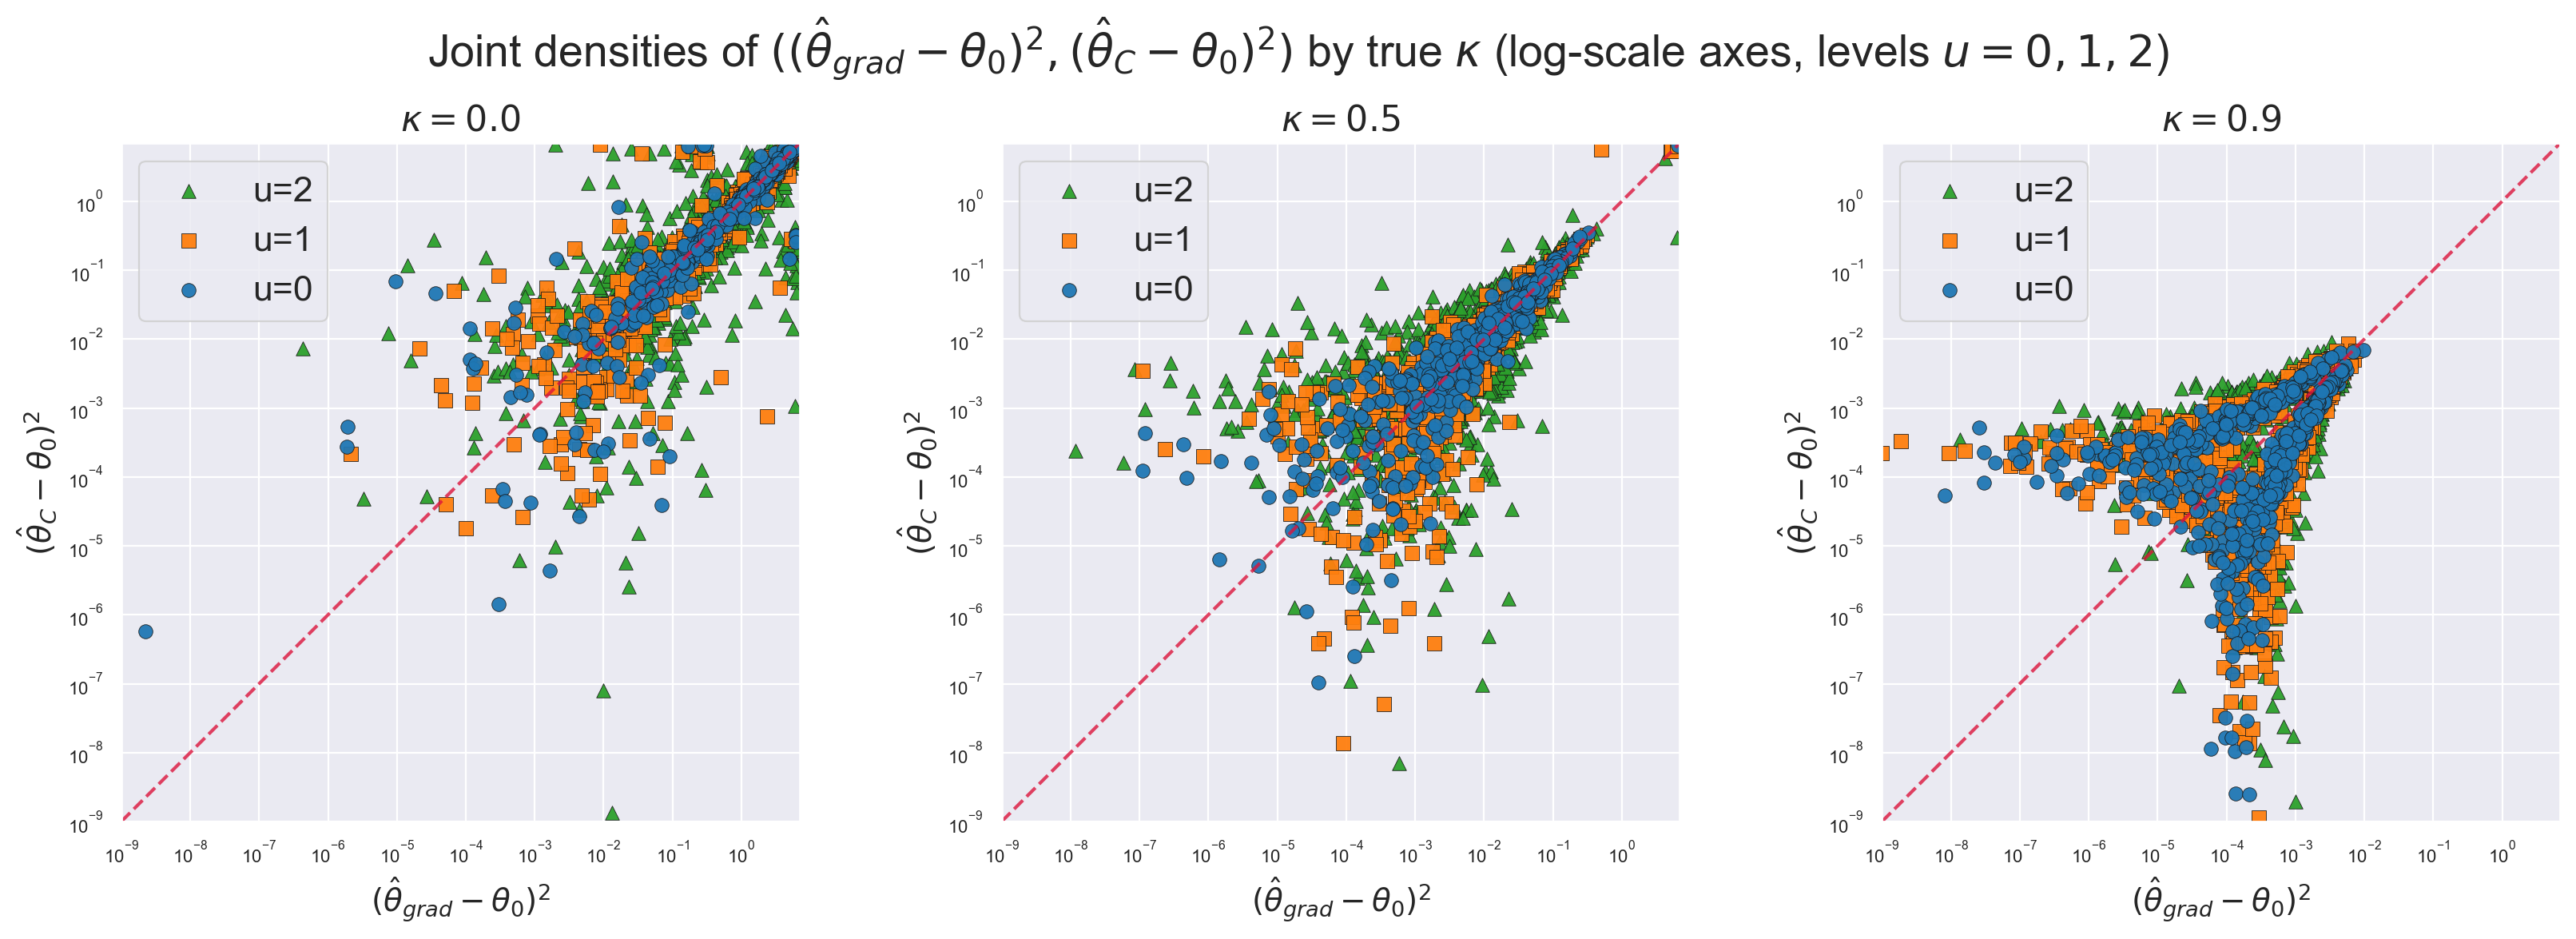

Generated squared-error joint density figure by true kappa and level u (log-scale).


In [8]:
# Squared-error diagnostics for $(\hat{\theta}_{grad}, \hat{\theta}_{C})$ with log-scaled axes.
req_cols = [
    'kappa', 'level_val', 'estimated_angle_gradients',
    'empirical_sine_cabana', 'empirical_cosine_cabana'
]
missing = [c for c in req_cols if c not in all_df.columns]
if missing:
    print(f"Error: Missing required columns for squared-error joint density: {missing}")
else:
    theta0 = float(globals().get('theta0', 1.0))
    eps = 1e-9  # Small offset preventing log(0) issues on both axes.

    df_sq = all_df.dropna(subset=req_cols).copy()

    if df_sq.empty:
        print('No rows available with complete angle information for squared-error plots.')
    else:
        df_sq['theta_grad_hat'] = df_sq['estimated_angle_gradients'].astype(float)
        df_sq['theta_c_hat'] = - 0.5 * np.arctan2(
            df_sq['empirical_sine_cabana'].astype(float),
            df_sq['empirical_cosine_cabana'].astype(float)
        )
        df_sq['err_grad_sq'] = (df_sq['theta_grad_hat'] - theta0) ** 2
        df_sq['err_c_sq'] = (df_sq['theta_c_hat'] - theta0) ** 2
        df_sq['err_grad_sq_plot'] = np.clip(df_sq['err_grad_sq'], eps, None)
        df_sq['err_c_sq_plot'] = np.clip(df_sq['err_c_sq'], eps, None)

        overall_mean_grad_sq = df_sq['err_grad_sq'].mean()
        overall_mean_c_sq = df_sq['err_c_sq'].mean()
        print(f"Overall mean squared errors: grad={overall_mean_grad_sq:.4e}, C={overall_mean_c_sq:.4e}")

        kappas_available = sorted(df_sq['kappa'].dropna().unique())
        preferred = [0.0, 0.5, 0.9]
        kappas_row = [k for k in preferred if k in kappas_available] or kappas_available[:3]

        if not kappas_row:
            print('No kappa values available for plotting.')
        else:
            print('Mean squared errors for plotted kappas:')
            for kappa_val in kappas_row:
                sub_means = df_sq[df_sq['kappa'] == kappa_val][['err_grad_sq', 'err_c_sq']].mean()
                print(f"  kappa={kappa_val:.2f}: grad={sub_means['err_grad_sq']:.4e}, C={sub_means['err_c_sq']:.4e}")

            grouped = (
                df_sq.groupby(['kappa', 'level_val'])[['err_grad_sq', 'err_c_sq']]
                .mean()
                .reset_index()
                .sort_values(['kappa', 'level_val'])
            )
            if not grouped.empty:
                print('\nMean squared errors by kappa and u level:')
                grouped_rounded = grouped.copy()
                grouped_rounded['err_grad_sq'] = grouped_rounded['err_grad_sq'].map(lambda v: f"{v:.4e}")
                grouped_rounded['err_c_sq'] = grouped_rounded['err_c_sq'].map(lambda v: f"{v:.4e}")
                print(grouped_rounded.rename(columns={'level_val': 'u'}).to_string(index=False))

            # Determine shared bounds for the log-log axes.
            vals_all = []
            for kappa_val in kappas_row:
                sub = df_sq[df_sq['kappa'] == kappa_val]
                for u in [0, 1, 2]:
                    d = sub[sub['level_val'] == u][['err_grad_sq_plot', 'err_c_sq_plot']]
                    if not d.empty:
                        vals_all.append(d.to_numpy())
                vals_all.append(np.array([[eps, eps]]))
            arr = np.vstack(vals_all)
            vmax = float(np.nanmax(arr)) if np.size(arr) else 1.0
            lim_min, lim_max = eps, vmax * 1.05

            level_order = [0, 1, 2]
            level_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}
            level_markers = {0: 'o', 1: 's', 2: '^'}

            ncols = len(kappas_row)
            fig, axes = plt.subplots(1, ncols, figsize=(5.5 * ncols, 5.2), dpi=dpi, constrained_layout=True)
            if ncols == 1:
                axes = np.array([axes])

            for ax, kappa_val in zip(axes, kappas_row):
                sub = df_sq[df_sq['kappa'] == kappa_val]
                if sub.empty:
                    ax.text(0.5, 0.5, f'No samples for $\\kappa={kappa_val:.2f}$', transform=ax.transAxes,
                            ha='center', va='center', fontsize=fontsize_labels)
                else:
                    for u in level_order[::-1]:
                        d = sub[sub['level_val'] == u][['err_grad_sq_plot', 'err_c_sq_plot']]
                        if d.empty:
                            continue
                        sns.scatterplot(
                            data=d,
                            x='err_grad_sq_plot',
                            y='err_c_sq_plot',
                            ax=ax,
                            s=size_scatter,
                            color=level_colors.get(u, 'C0'),
                            alpha=alpha_scatter,
                            edgecolor='k',
                            linewidth=linewidths_scatter,
                            marker=level_markers.get(u, 'o'),
                            label=f'u={int(u)}'
                        )

                ax.plot([lim_min, lim_max], [lim_min, lim_max], '--', color='crimson', linewidth=1.5, alpha=0.8)
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim([lim_min, lim_max])
                ax.set_ylim([lim_min, lim_max])
                ax.set_aspect('equal', adjustable='box')
                ax.set_xlabel(r'$(\hat{\theta}_{grad}-\theta_0)^2$', fontsize=fontsize_labels)
                ax.set_ylabel(r'$(\hat{\theta}_{C}-\theta_0)^2$', fontsize=fontsize_labels)
                ax.set_title(f'$\\kappa={kappa_val:.1f}$', fontsize=fontsize_title)
                ax.tick_params(axis='both', labelsize=fontsize_ticks)
                ax.legend(loc='upper left', fontsize=fontsize_legend)

            fig.suptitle(r'Joint densities of $((\hat{\theta}_{grad}-\theta_0)^2,(\hat{\theta}_{C}-\theta_0)^2)$ by true $\kappa$ (log-scale axes, levels $u=0,1,2$)',
                         y=1.1, fontsize=fontsize_suptitle)
            plt.show()
            print('Generated squared-error joint density figure by true kappa and level u (log-scale).')

Using LKC column: estimated_kappa_BD


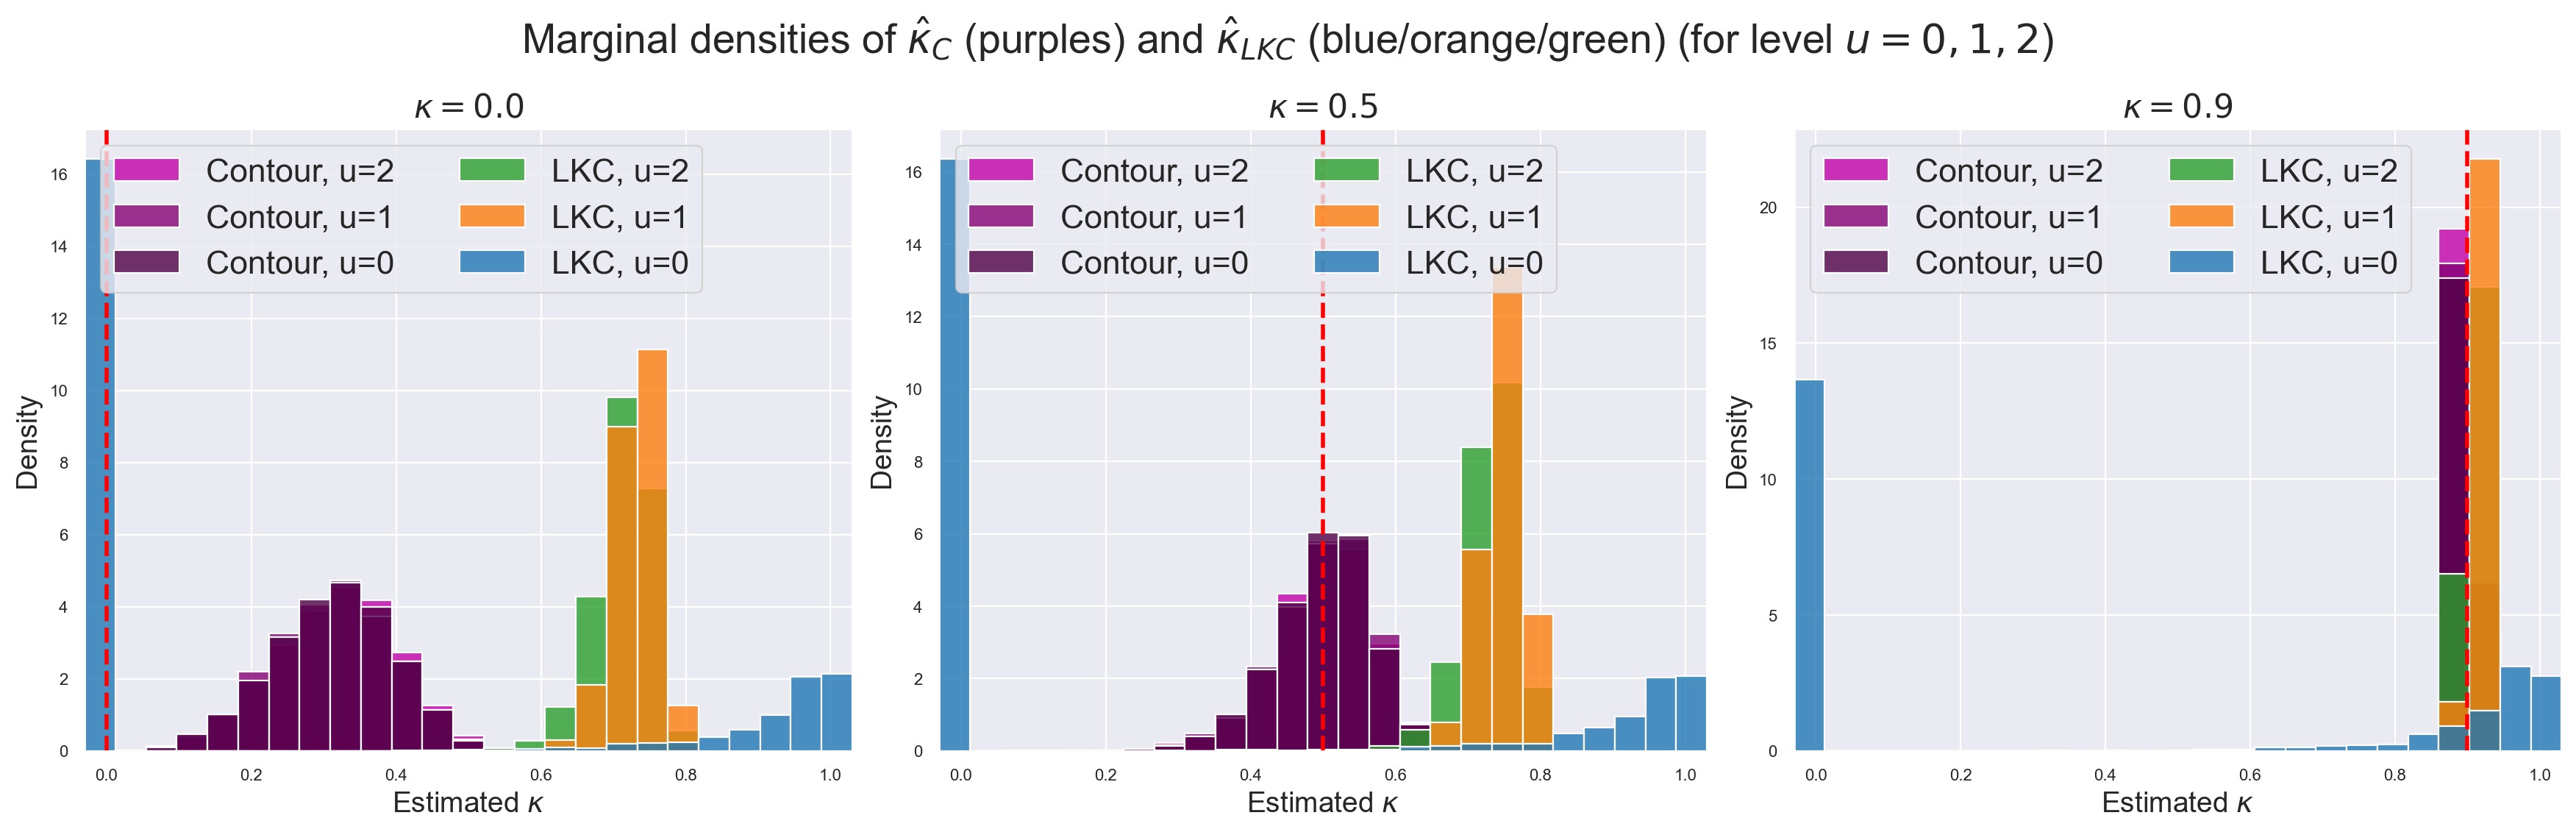

Generated 1×3 marginal density figure for kappa_C and kappa_LKC (column: estimated_kappa_BD).


In [9]:
# Marginal densities of $\hat{\kappa}_{LKC}$ and $\hat{\kappa}_{C}$ across true κ values.
# For each panel (fixed κ) we draw three histograms per estimator (u = 0, 1, 2).
# Palette: contour estimates use purples, LKC estimates use blue/orange/green.

# Locate the LKC column automatically (fallback to BD if the primary column is missing).
colmap_lower = {c.lower(): c for c in all_df.columns}
lkc_candidates = [
    'estimated_kappa_lkc', 'kappa_lkc', 'estimated_kappa_LKC', 'kappa_LKC',
    'estimated_kappa_gradients_lkc', 'kappa_gradients_lkc',
    'estimated_kappa_bd', 'kappa_bd'
]
lkc_col = None
for key in lkc_candidates:
    if key.lower() in colmap_lower:
        lkc_col = colmap_lower[key.lower()]
        break

if lkc_col is None:
    print("Error: Could not find an LKC column (tried:", lkc_candidates, ") in DataFrame. Aborting plot.")
else:
    print(f"Using LKC column: {lkc_col}")

    req_cols = ['kappa', 'level_val', 'estimated_kappa_cabana', lkc_col]
    missing = [c for c in req_cols if c not in all_df.columns]
    if missing:
        print(f"Error: Missing required columns: {missing}")
    else:
        present_kappas = sorted(all_df['kappa'].dropna().unique().tolist())
        preferred = [0, 0.5, 0.9]
        kappas_row = [k for k in preferred if k in present_kappas] or present_kappas[:3]

        # Collect all samples first so that a single x-axis range covers both estimators.
        vals = []
        for k in kappas_row:
            sub = all_df[all_df['kappa'] == k]
            for u in [0,1,2]:
                d = sub[sub['level_val'] == u][['estimated_kappa_cabana', lkc_col]].dropna(how='all')
                if not d.empty:
                    if 'estimated_kappa_cabana' in d:
                        vals.append(d['estimated_kappa_cabana'].dropna().to_numpy())
                    if lkc_col in d:
                        vals.append(d[lkc_col].dropna().to_numpy())
            vals.append(np.array([k]))
        if vals:
            concat = np.concatenate(vals) if len(vals)>1 else vals[0]
            vmin, vmax = float(np.nanmin(concat)), float(np.nanmax(concat))
            pad = max(0.03*(vmax - vmin), 0.02)
            lim_min, lim_max = vmin - pad, vmax + pad
        else:
            lim_min, lim_max = -0.1, 1.1

        contour_colors = {0:"#500045", 1:"#850174", 2:"#C300A9"}  # dark→light purples
        lkc_colors     = {0:'tab:blue', 1:'tab:orange', 2:'tab:green'}  # dark→light for LKC

        bins = np.linspace(lim_min, lim_max, 26)

        ncols = len(kappas_row)
        fig, axes = plt.subplots(1, ncols, figsize=(5.8*ncols, 5.0), dpi=dpi, constrained_layout=True)
        if ncols == 1:
            axes = np.array([axes])

        for ax, k in zip(axes, kappas_row):
            sub = all_df[all_df['kappa'] == k]

            # Contour (Cabana) histograms by level.
            for u in [2,1,0]:  # reverse order for better visibility
                dC = sub[sub['level_val'] == u]['estimated_kappa_cabana'].dropna()
                if not dC.empty:
                    sns.histplot(dC, ax=ax, bins=bins, stat='density', alpha=0.8, color=contour_colors[u],
                                 edgecolor=None, label=f'Contour, u={u}')
            # LKC histograms by level.
            for u in [2,1,0]:
                dL = sub[sub['level_val'] == u][lkc_col].dropna()
                if not dL.empty:
                    sns.histplot(dL, ax=ax, bins=bins, stat='density', alpha=0.8, color=lkc_colors[u],
                                 edgecolor=None, label=f'LKC, u={u}')

            ax.axvline(k, color='red', linestyle='--', linewidth=2.0)
            ax.set_xlim(lim_min, lim_max)
            ax.set_xlabel('Estimated $\\kappa$', fontsize=fontsize_labels)
            ax.set_ylabel('Density', fontsize=fontsize_labels)
            ax.set_title(f'$\\kappa={k:.1f}$', fontsize=fontsize_title)
            ax.tick_params(axis='both', labelsize=fontsize_ticks)
            ax.legend(fontsize=fontsize_legend, ncol=2, loc='upper left')

        fig.suptitle('Marginal densities of $\\hat{\\kappa}_{C}$ (purples) and $\\hat{\\kappa}_{LKC}$ (blue/orange/green) (for level $u=0,1,2$)', y=1.1, fontsize=fontsize_suptitle)
        plt.show()
        print('Generated 1×3 marginal density figure for kappa_C and kappa_LKC (column: ' + lkc_col + ').')

Using gradient column: estimated_kappa_gradients


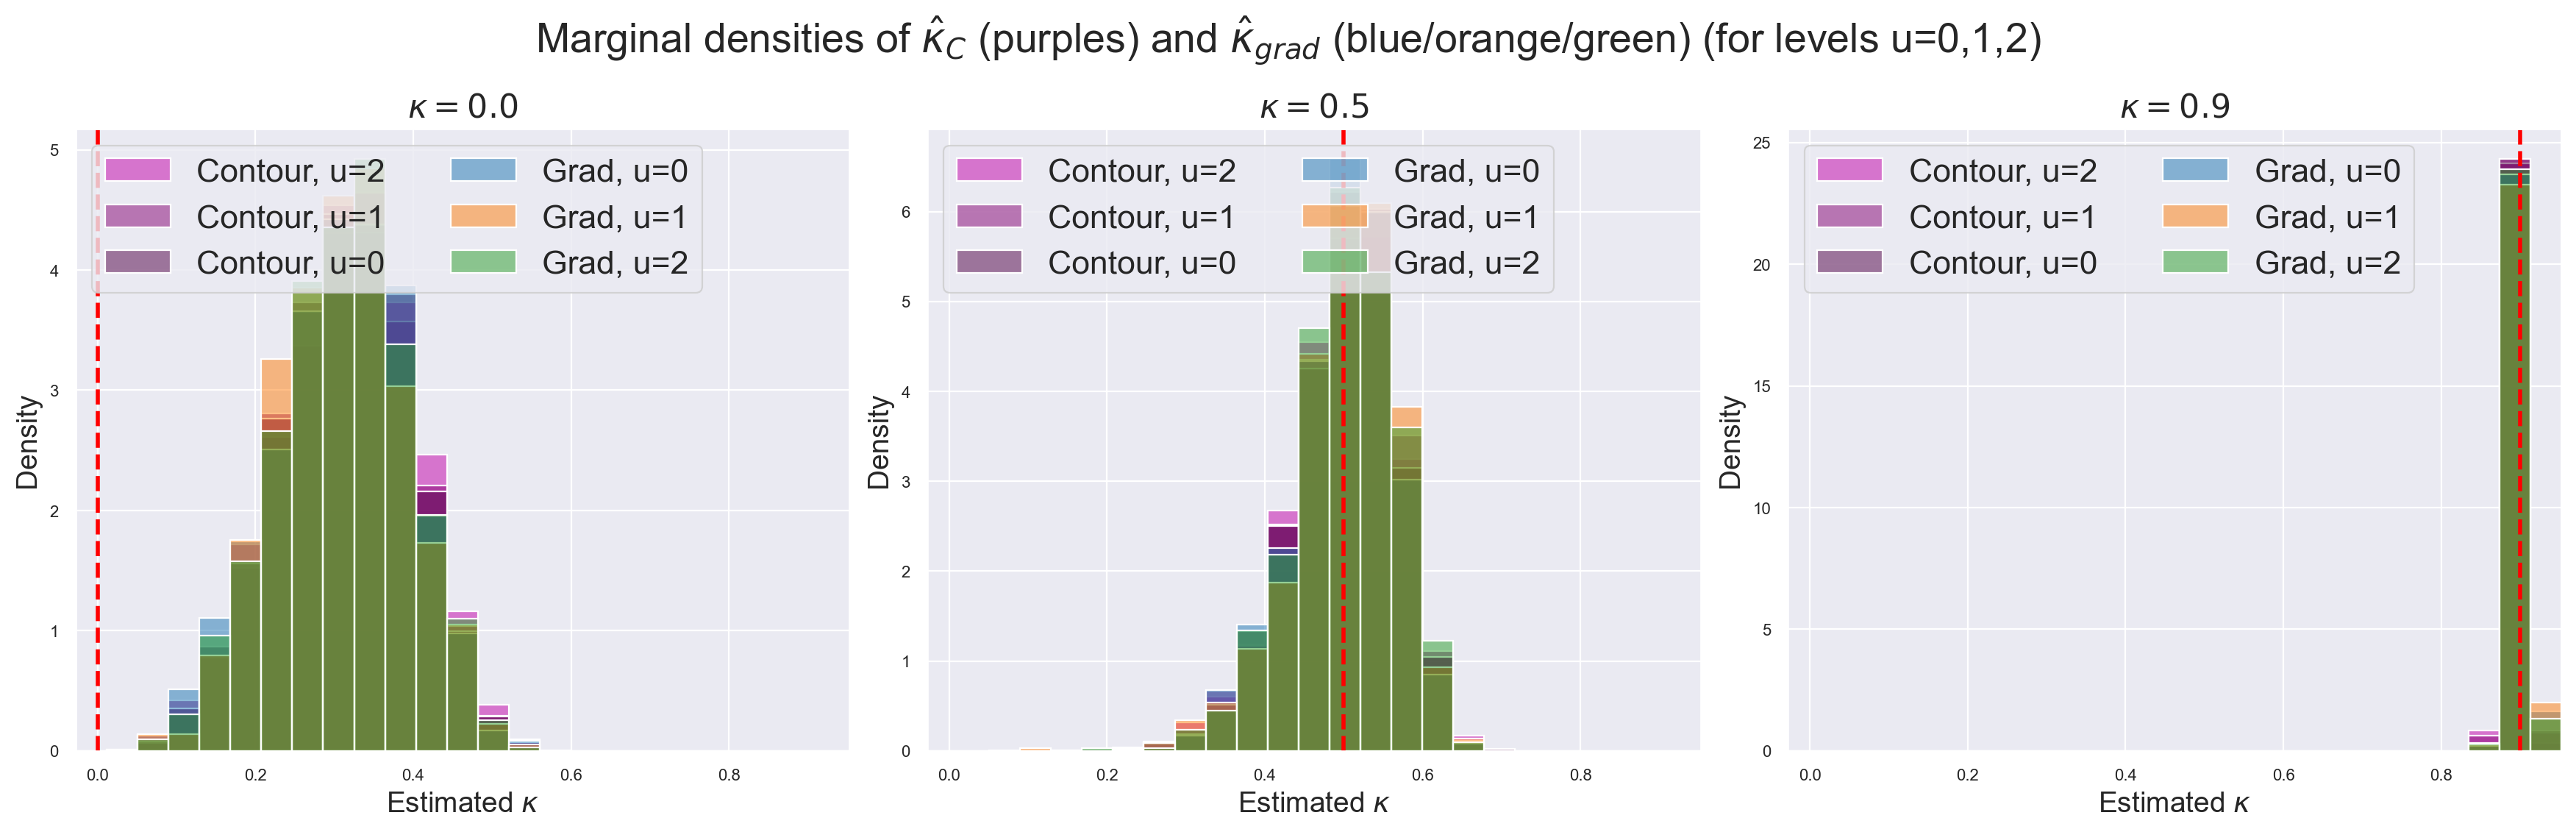

Generated 1×3 marginal density figure for kappa_C vs kappa_grad (column: estimated_kappa_gradients).


In [10]:
# Marginal densities of $\hat{\kappa}_{grad}$ vs $\hat{\kappa}_{C}$ (structure mirrors the LKC comparison).

# Detect the gradient-based estimator column automatically.
colmap_lower = {c.lower(): c for c in all_df.columns}
grad_candidates = [
    'estimated_kappa_gradients', 'kappa_gradients',
    'estimated_kappa_grad', 'kappa_grad',
    'estimated_kappa_full', 'kappa_full'
]
grad_col = None
for key in grad_candidates:
    if key.lower() in colmap_lower:
        grad_col = colmap_lower[key.lower()]
        break

if grad_col is None:
    print('Error: Could not find a gradient-based kappa column (tried: ', grad_candidates, '). Aborting plot.')
else:
    print(f'Using gradient column: {grad_col}')

    req_cols = ['kappa', 'level_val', 'estimated_kappa_cabana', grad_col]
    missing = [c for c in req_cols if c not in all_df.columns]
    if missing:
        print(f'Error: Missing required columns: {missing}')
    else:
        present_kappas = sorted(all_df['kappa'].dropna().unique().tolist())
        preferred = [0, 0.5, 0.9]
        kappas_row = [k for k in preferred if k in present_kappas] or present_kappas[:3]

        # Determine a shared x-range that covers both contour and gradient distributions.
        vals = []
        for k in kappas_row:
            sub = all_df[all_df['kappa'] == k]
            for u in [2,1,0]:
                d = sub[sub['level_val'] == u][['estimated_kappa_cabana', grad_col]].dropna(how='all')
                if not d.empty:
                    if 'estimated_kappa_cabana' in d:
                        vals.append(d['estimated_kappa_cabana'].dropna().to_numpy())
                    if grad_col in d:
                        vals.append(d[grad_col].dropna().to_numpy())
            vals.append(np.array([k]))
        if vals:
            concat = np.concatenate(vals) if len(vals)>1 else vals[0]
            vmin, vmax = float(np.nanmin(concat)), float(np.nanmax(concat))
            pad = max(0.03*(vmax - vmin), 0.02)
            lim_min, lim_max = vmin - pad, vmax + pad
        else:
            lim_min, lim_max = -0.1, 1.1

        contour_colors = {0:'#500045', 1:'#850174', 2:'#C300A9'}  # purples for the contour estimator
        grad_colors    = {0:'tab:blue', 1:'tab:orange', 2:'tab:green'}  # blue/orange/green for gradients
        bins = np.linspace(lim_min, lim_max, 26)

        ncols = len(kappas_row)
        fig, axes = plt.subplots(1, ncols, figsize=(5.8*ncols, 5.0), dpi=dpi, constrained_layout=True)
        if ncols == 1:
            axes = np.array([axes])

        for ax, k in zip(axes, kappas_row):
            sub = all_df[all_df['kappa'] == k]

            for u in [2,1,0]:
                dC = sub[sub['level_val'] == u]['estimated_kappa_cabana'].dropna()
                if not dC.empty:
                    sns.histplot(dC, ax=ax, bins=bins, stat='density', alpha=0.5,
                                 color=contour_colors[u], edgecolor=None, label=f'Contour, u={u}')
            for u in [0,1,2]:
                dG = sub[sub['level_val'] == u][grad_col].dropna()
                if not dG.empty:
                    sns.histplot(dG, ax=ax, bins=bins, stat='density', alpha=0.5,
                                 color=grad_colors[u], edgecolor=None, label=f'Grad, u={u}')

            ax.axvline(k, color='red', linestyle='--', linewidth=2.0)
            ax.set_xlim(lim_min, lim_max)
            ax.set_xlabel('Estimated $\\kappa$', fontsize=fontsize_labels)
            ax.set_ylabel('Density', fontsize=fontsize_labels)
            ax.set_title(f'$\\kappa={k:.1f}$', fontsize=fontsize_title)
            ax.tick_params(axis='both', labelsize=fontsize_ticks)
            ax.legend(fontsize=fontsize_legend, ncol=2, loc='upper left')

        fig.suptitle('Marginal densities of $\\hat{\\kappa}_{C}$ (purples) and $\\hat{\\kappa}_{grad}$ (blue/orange/green) (for levels u=0,1,2)', y=1.1, fontsize=fontsize_suptitle)
        plt.show()
        print('Generated 1×3 marginal density figure for kappa_C vs kappa_grad (column: ' + grad_col + ').')

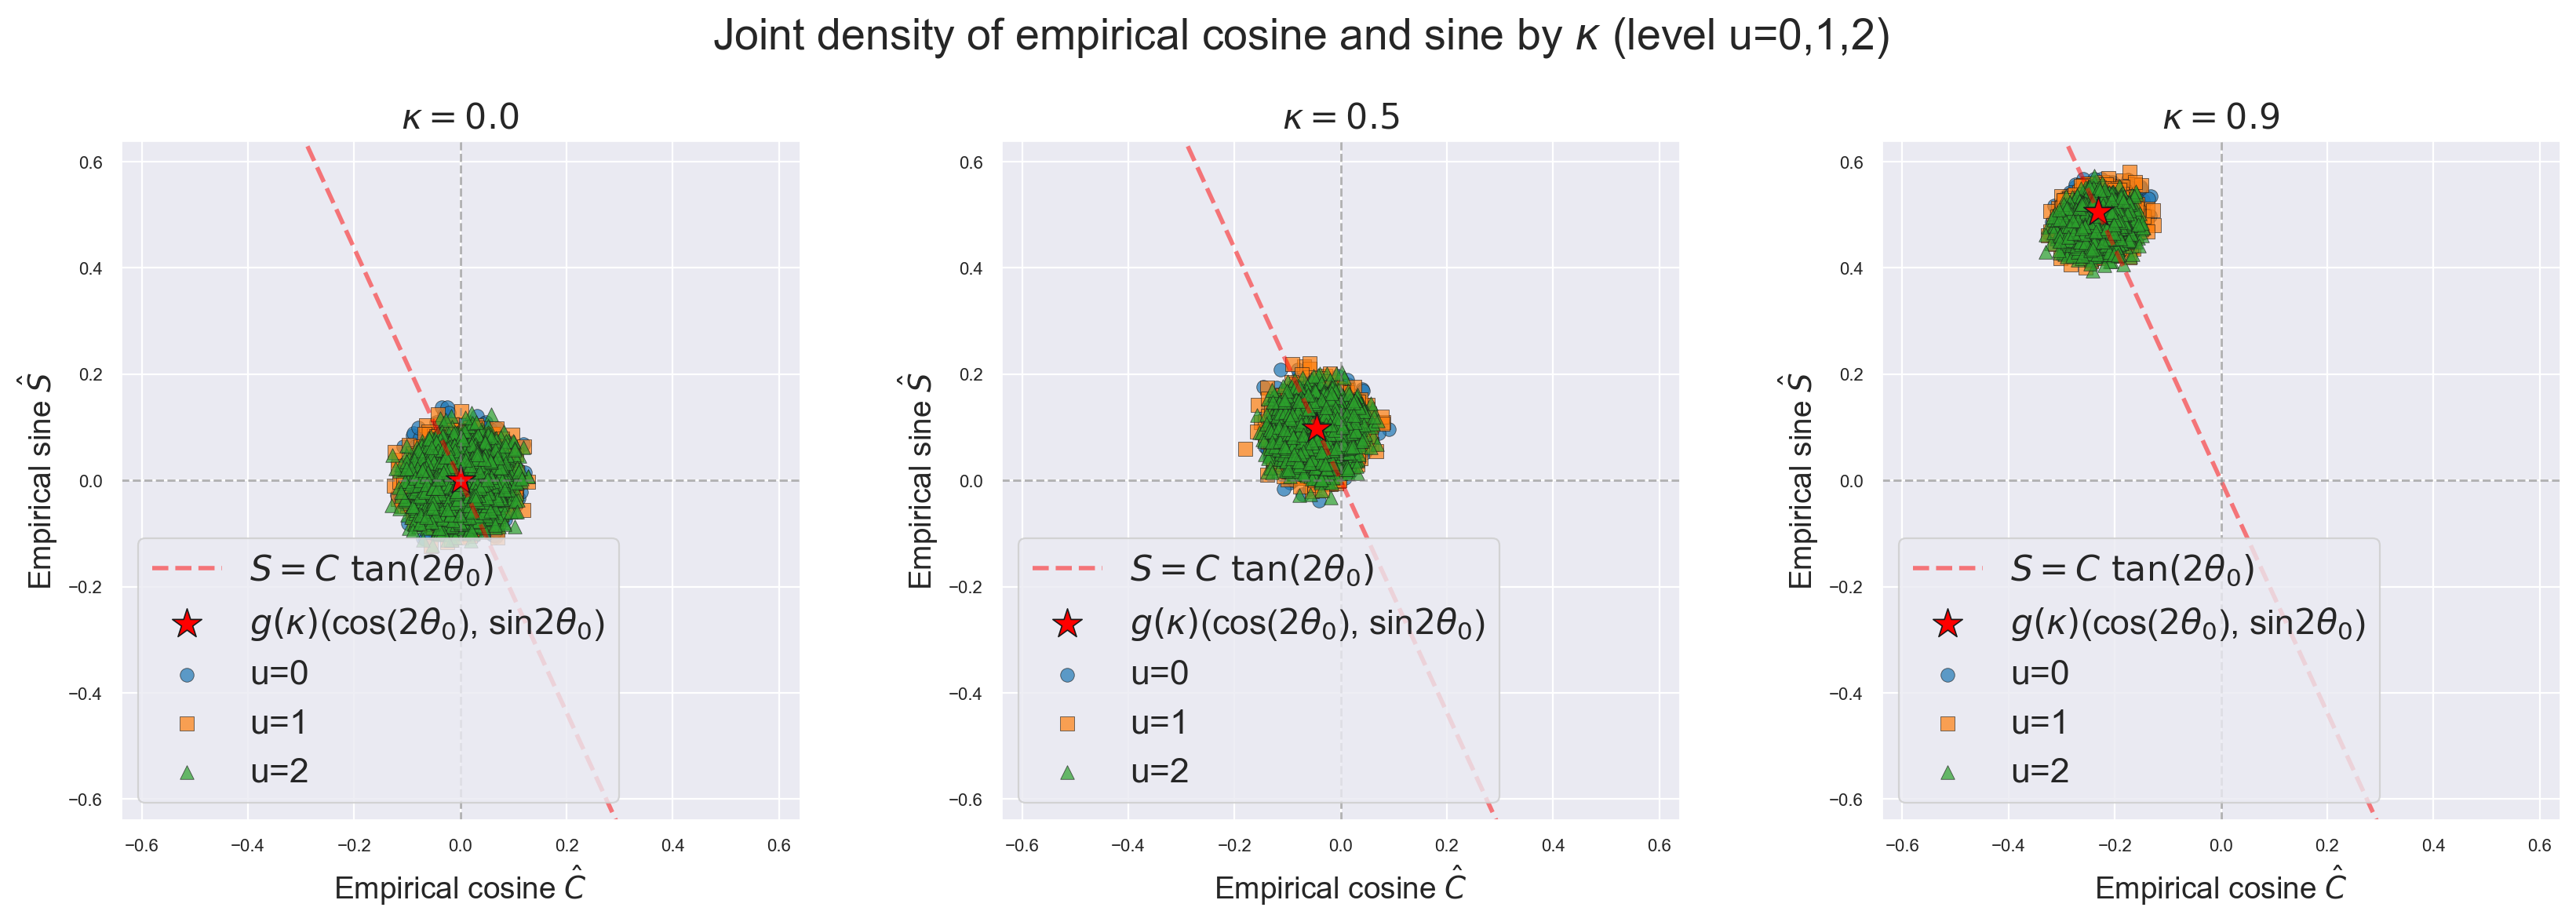

Generated 1×3 joint density figure for empirical cosine/sine by kappa.


In [11]:
# Scatter plots of the empirical cosine/sine components normalised by perimeter, one column per κ.

# Required Cabana statistics.
req_cols = [
    'kappa', 'level_val', 'empirical_cosine_cabana', 'empirical_sine_cabana',
    'perimeter_cabana', 'angle_rad'
]
missing = [c for c in req_cols if c not in all_df.columns]
if missing:
    print(f"Error: Missing required columns in all_df: {missing}")
else:
    # Reuse the κ ordering defined earlier when possible for visual consistency.
    try:
        kappas = list(kappa_aimed)
    except NameError:
        kappas = sorted(all_df['kappa'].unique().tolist())

    # Preserve the canonical ordering [0, 0.5, 0.9] whenever available.
    in_df = set(all_df['kappa'].unique())
    present_kappas = [k for k in [0, 0.5, 0.9] if k in in_df] or sorted([k for k in kappas if k in in_df])

    if len(present_kappas) == 0:
        print("No kappa values available to plot.")
    else:
        # Aggregate all normalised points to determine shared axis limits.
        all_points = []
        for k in present_kappas:
            dfk = all_df[all_df['kappa'] == k]
            for u in [0, 1, 2]:
                d = dfk[dfk['level_val'] == u][['empirical_cosine_cabana', 'empirical_sine_cabana', 'perimeter_cabana']].dropna()
                if not d.empty:
                    d = d[d['perimeter_cabana'] > 0]
                if not d.empty:
                    vals = d[['empirical_cosine_cabana', 'empirical_sine_cabana']].to_numpy() / d['perimeter_cabana'].to_numpy()[:, None]
                    all_points.append(vals)
        if all_points:
            concat = np.vstack(all_points)
            L = float(np.nanmax(np.abs(concat)))
            lim = min(max(L * 1.1, 0.3), 1.5)
        else:
            lim = 1.0

        level_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}
        level_markers = {0: 'o', 1: 's', 2: '^'}

        ncols = len(present_kappas)
        fig, axes = plt.subplots(1, ncols, figsize=(5.6 * ncols, 5.2), dpi=200, constrained_layout=True)
        if ncols == 1:
            axes = np.array([axes])

        for ax, k in zip(axes, present_kappas):
            dfk = all_df[all_df['kappa'] == k]
            theta0 = float(dfk['angle_rad'].dropna().iloc[0]) if dfk['angle_rad'].notna().any() else 0.0

            # Reference line S = C * tan(2θ0) describing the theoretical phase relationship.
            slope = np.tan(2)  
            intercept = 0
            x_vals = np.array([-0.6, 0.6])
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals, y_vals, '--', color='red', alpha=0.5, linewidth=2, label='$S = C\\ \\tan(2\\theta_0)$')

            # Theoretical Cabana target point g(κ)(cos 2θ0, sin 2θ0).
            try:
                gk = float(elliptic_cabana(k))
            except Exception:
                gk = np.nan
                
            if np.isfinite(gk):
                star_x = gk * np.cos(2 * theta0)
                star_y = gk * np.sin(2 * theta0)
                ax.scatter([star_x], [star_y], marker='*', s=size_scatter_star, color='red', edgecolor='k', linewidths=linewidths_scatter_star, label='$g(\\kappa)$(cos($2\\theta_0$), sin$2\\theta_0$)')

            # Normalised empirical points per level.
            for u in [0, 1, 2]:
                d = dfk[dfk['level_val'] == u][['empirical_cosine_cabana', 'empirical_sine_cabana', 'perimeter_cabana']].dropna()
                if not d.empty:
                    d = d[d['perimeter_cabana'] > 0]
                if not d.empty:
                    vals = d[['empirical_cosine_cabana', 'empirical_sine_cabana']].to_numpy() / d['perimeter_cabana'].to_numpy()[:, None]
                    ax.scatter(vals[:, 0], -vals[:, 1], s=size_scatter, alpha=0.7, color=level_colors.get(u, 'C0'), edgecolor='k', linewidths=linewidths_scatter, marker=level_markers.get(u, 'o'), label=f'u={u}')
            ax.scatter([star_x], [star_y], marker='*', s=size_scatter_star, color='red', edgecolor='k', linewidths=0.6)
            ax.set_title(f'$\\kappa={k:.1f}$', fontsize=fontsize_title)
            ax.set_xlabel('Empirical cosine $\\hat C$', fontsize=fontsize_labels)
            ax.set_ylabel('Empirical sine $\\hat S$', fontsize=fontsize_labels)
            ax.set_aspect('equal', adjustable='box')
            ax.axhline(0, color='grey', linestyle='--', linewidth=1, alpha=0.6)
            ax.axvline(0, color='grey', linestyle='--', linewidth=1, alpha=0.6)
            ax.set_xlim([-lim, lim])
            ax.set_ylim([-lim, lim])
            ax.legend(loc='lower left', fontsize=fontsize_legend)
            ax.tick_params(axis='both', labelsize=fontsize_ticks)

        fig.suptitle('Joint density of empirical cosine and sine by $\\kappa$ (level u=0,1,2)', y=1.1, fontsize=fontsize_suptitle)
        plt.show()
        print('Generated 1×3 joint density figure for empirical cosine/sine by kappa.')

T communs: [np.float64(200.0)]
Debug: fs=1000, lvl=0, H0 n=7600, H1 n=2600
Debug: fs=1000, lvl=1, H0 n=5900, H1 n=2900
Debug: fs=1000, lvl=2, H0 n=7600, H1 n=3600


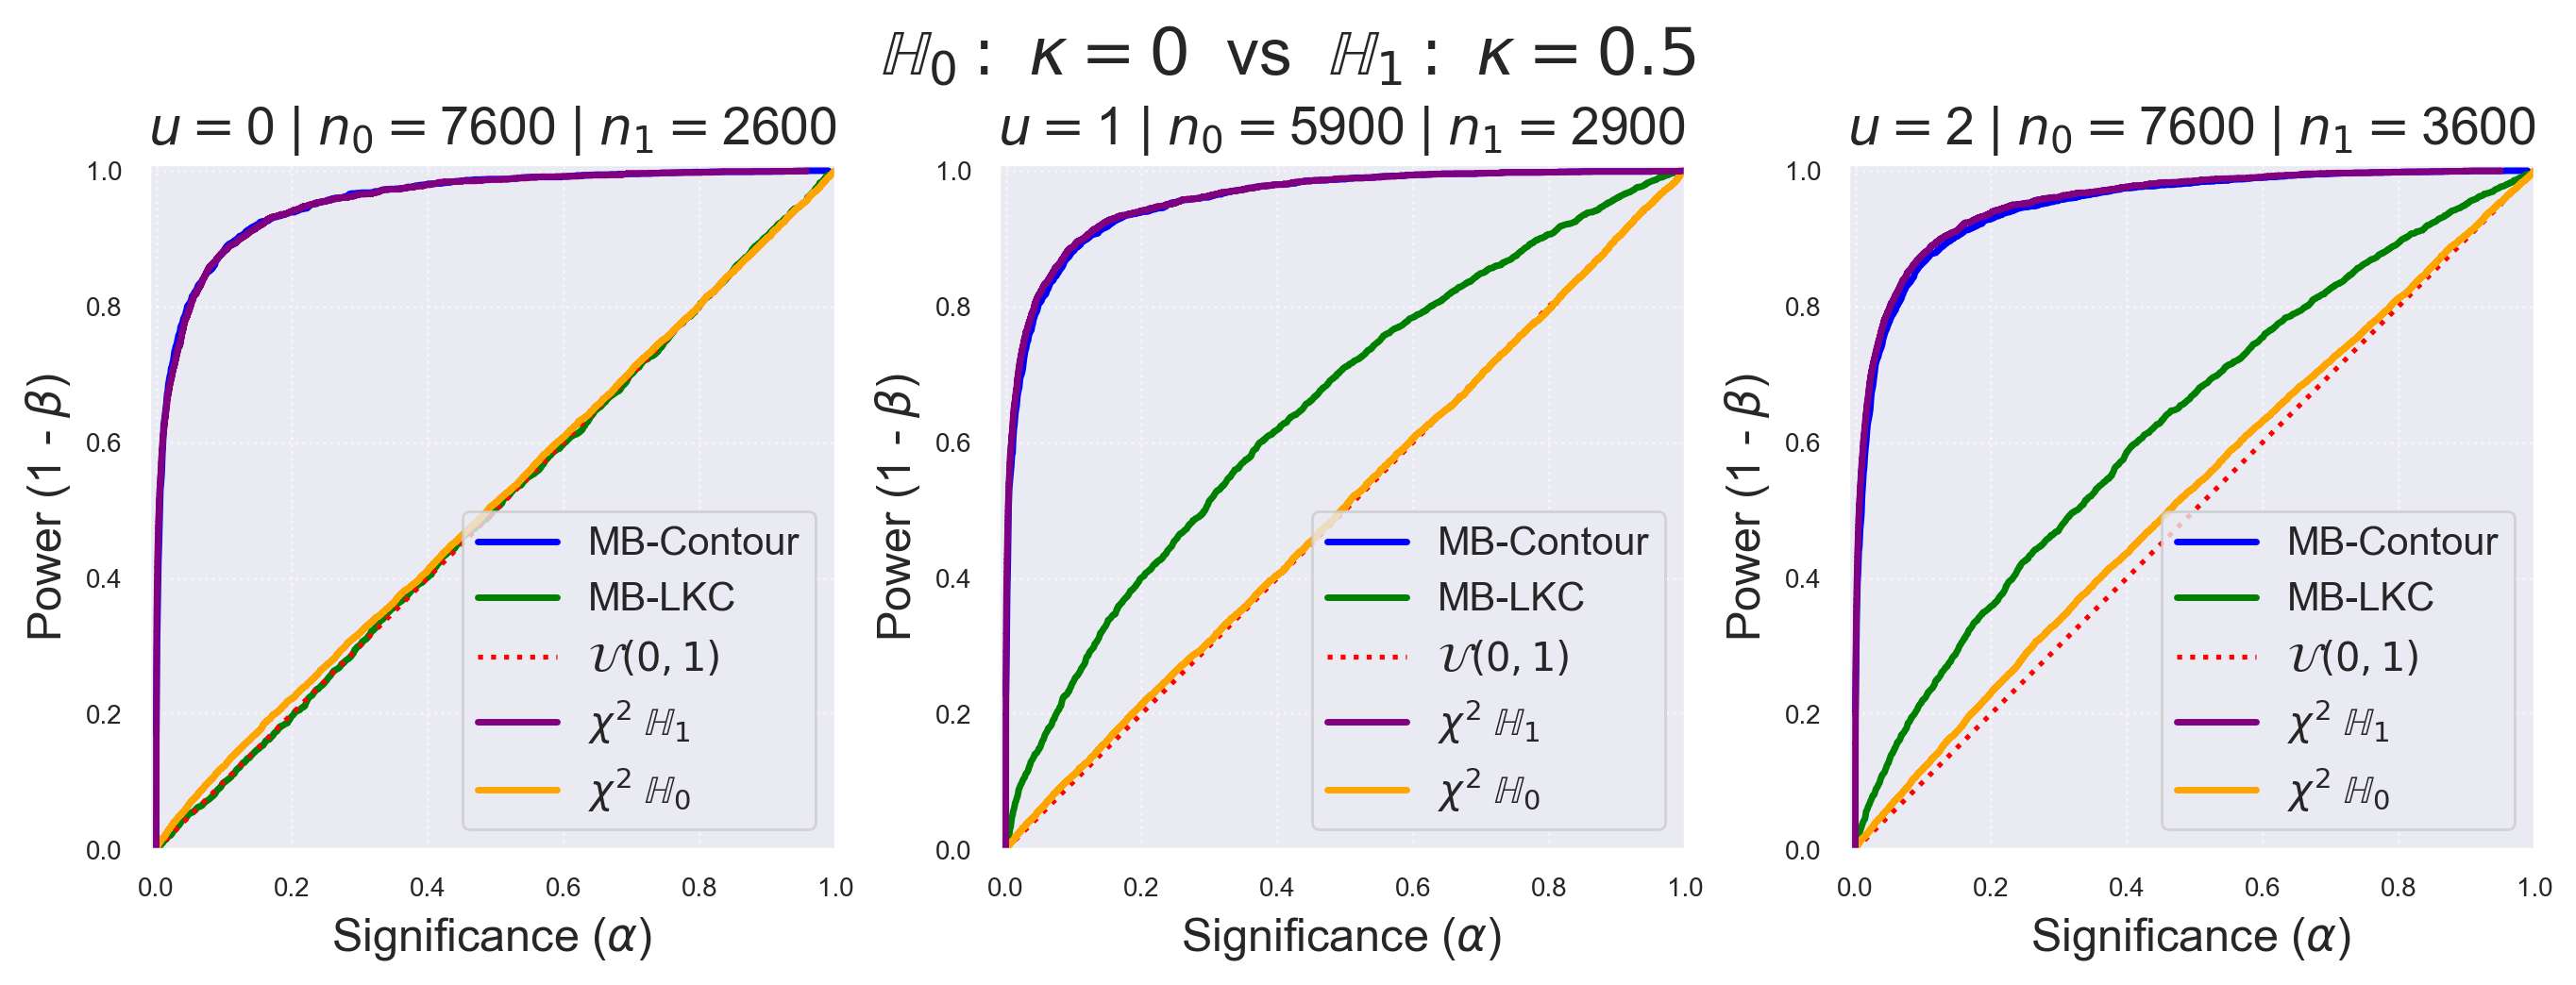

Terminé: génération des courbes de puissance.


In [12]:
# Global configuration of the power-curve generation block.
filter_single_level = False
single_level_value = 0
kappa_alternative = 0.5
min_samples_for_percentile = 1
save_figs = False  # Set to True to persist the generated figures.
output_prefix = "fig-powers"

# Optional debug flag to disable LaTeX in figure legends.
use_latex_in_legends = True
if not use_latex_in_legends:
    print("Legend LaTeX disabled (debug mode)")

def legend_label(key: str) -> str:
    latex_map = {
        'uniform': '$\\mathcal{U}(0,1)$',
        'chi2_h0': '$\\chi^2$ $\\mathbb{H}_0$',
        'chi2_h1': '$\\chi^2$ $\\mathbb{H}_1$'
    }
    plain_map = {
        'uniform': 'U(0,1)',
        'chi2_h0': 'chi2 H0',
        'chi2_h1': 'chi2 H1'
    }
    table = latex_map if use_latex_in_legends else plain_map
    return table[key]

# Columns needed for the power analysis.
required_columns = ['kappa', 'field_size', 'level_val', 'statistics_BD', 'empirical_cosine_cabana',
                    'empirical_sine_cabana', 'perimeter_cabana', 'T_parameter', 'chi2_pvalue', 'factor_divide']
missing_initial = [c for c in required_columns if c not in all_df.columns]
if missing_initial:
    print(f"Erreur: colonnes manquantes dans all_df: {missing_initial}")
else:
    work_df = all_df.copy()
    if filter_single_level:
        work_df = work_df[work_df['level_val'] == single_level_value]
        if work_df.empty:
            print(f"Aucune donnée après filtrage level_val == {single_level_value}.")
    
    df_h0_full = work_df[work_df['kappa'] == 0].copy()
    df_h1_full = work_df[work_df['kappa'] == kappa_alternative].copy()

    if df_h0_full.empty or df_h1_full.empty:
        print(f"Données insuffisantes: H0 (kappa=0) lignes={len(df_h0_full)}, H1 (kappa={kappa_alternative}) lignes={len(df_h1_full)}")
    else:
        common_t_params = sorted(list(set(df_h0_full['T_parameter'].unique()) & set(df_h1_full['T_parameter'].unique())))
        if not common_t_params:
            print(f"Aucun T_parameter commun entre kappa=0 et kappa={kappa_alternative}.")
        else:
            print(f"T communs: {common_t_params}")
            alphas = np.linspace(0.0001, 0.99, 1000)  # Dense grid for smooth power curves.


            fig_counter = 0
            for t_param in common_t_params:
                df_h0_t = df_h0_full[df_h0_full['T_parameter'] == t_param]
                df_h1_t = df_h1_full[df_h1_full['T_parameter'] == t_param]

                tp_col = 'total_points_generated'
                if tp_col in work_df.columns:
                    common_tp_values = sorted(list(set(df_h0_t[tp_col].unique()) & set(df_h1_t[tp_col].unique())))
                    if not common_tp_values:
                        common_tp_values = [None]
                else:
                    common_tp_values = [None]

                for tp_val in common_tp_values:
                    df_h0_tp_loop = df_h0_t
                    df_h1_tp_loop = df_h1_t
                    tp_title_suffix = ""
                    if tp_val is not None:
                        df_h0_tp_loop = df_h0_t[df_h0_t[tp_col] == tp_val]
                        df_h1_tp_loop = df_h1_t[df_h1_t[tp_col] == tp_val]
                        if df_h0_tp_loop.empty or df_h1_tp_loop.empty:
                            continue
                        tp_val_eng = f"{tp_val:.0e}" if tp_val >= 1e3 else str(int(tp_val))
                        tp_title_suffix = f", Pts Gen$=10^7$"

                    unique_field_sizes = sorted(list(set(df_h0_tp_loop['field_size'].unique()) & set(df_h1_tp_loop['field_size'].unique())))
                    unique_level_vals = sorted(list(set(df_h0_tp_loop['level_val'].unique()) & set(df_h1_tp_loop['level_val'].unique())))
                    if not unique_field_sizes or not unique_level_vals:
                        continue

                    nrows_plot = len(unique_field_sizes)
                    ncols_plot = len(unique_level_vals)

                    fig, axes = plt.subplots(nrows=nrows_plot, ncols=ncols_plot,
                                             figsize=(3.6 * ncols_plot, 3.6 * nrows_plot),
                                             squeeze=False, constrained_layout=True, dpi=250)
                    fig.suptitle('$\\mathbb{H}_0:\\ \\kappa=0$  vs  $\\mathbb{H}_1:\\ \\kappa=0.5$', fontsize=fontsize_suptitle, y=1.1)

                    for i_fs, fs_val in enumerate(unique_field_sizes):
                        for j_lvl, lvl_val in enumerate(unique_level_vals):
                            ax = axes[i_fs, j_lvl]

                            mask_h0 = (df_h0_tp_loop['field_size'] == fs_val) & (df_h0_tp_loop['level_val'] == lvl_val)
                            mask_h1 = (df_h1_tp_loop['field_size'] == fs_val) & (df_h1_tp_loop['level_val'] == lvl_val)

                            # Extract the raw statistics for each hypothesis.
                            d0_cos = df_h0_tp_loop.loc[mask_h0, 'empirical_cosine_cabana'].dropna()
                            d1_cos = df_h1_tp_loop.loc[mask_h1, 'empirical_cosine_cabana'].dropna()
                            d0_sin = df_h0_tp_loop.loc[mask_h0, 'empirical_sine_cabana'].dropna()
                            d1_sin = df_h1_tp_loop.loc[mask_h1, 'empirical_sine_cabana'].dropna()
                            d0_per = df_h0_tp_loop.loc[mask_h0, 'perimeter_cabana'].dropna()
                            d1_per = df_h1_tp_loop.loc[mask_h1, 'perimeter_cabana'].dropna()
                            d0_bd = df_h0_tp_loop.loc[mask_h0, 'statistics_BD'].dropna()
                            d1_bd = df_h1_tp_loop.loc[mask_h1, 'statistics_BD'].dropna()
                            print(f"Debug: fs={fs_val}, lvl={lvl_val}, H0 n={len(d0_bd)}, H1 n={len(d1_bd)}")

                            # Cabana statistics with zero-division guard.
                            if not d0_per.empty:
                                d0_cab = (d0_cos**2 + d0_sin**2) / np.maximum(d0_per, 1e-30)**2
                            else:
                                d0_cab = pd.Series(dtype=float)
                            if not d1_per.empty:
                                d1_cab = (d1_cos**2 + d1_sin**2) / np.maximum(d1_per, 1e-30)**2
                            else:
                                d1_cab = pd.Series(dtype=float)

                            ax.set_title(f'$u=${int(lvl_val)} | $n_0=${len(df_h0_tp_loop.loc[mask_h0, 'empirical_cosine_cabana'])} | $n_1=${len(df_h1_tp_loop.loc[mask_h1, 'empirical_cosine_cabana'])}', fontsize=fontsize_title)
                            ax.set_xlabel('Significance ($\\alpha$)', fontsize=fontsize_labels)
                            ax.set_ylabel('Power (1 - $\\beta$)', fontsize=fontsize_labels)
                            ax.tick_params(axis='both', labelsize=fontsize_ticks)
                            ax.grid(True, linestyle=':', alpha=0.55)
                            ax.set_xlim([-0.01, 1])
                            ax.set_ylim([0, 1.01])

                            if d0_cab.empty and d1_cab.empty and d0_bd.empty and d1_bd.empty:
                                ax.text(0.5, 0.5, 'Données insuffisantes', ha='center', va='center', transform=ax.transAxes, fontsize=7)
                                continue

                            power_cabana_vals = []
                            power_bd_vals = []

                            # MB-Contour: large statistics reject H0.
                            if len(d0_cab) >= min_samples_for_percentile and not d1_cab.empty:
                                q_cab = np.percentile(d0_cab, 100 * (1 - alphas))
                                arr1 = d1_cab.to_numpy()[:, None]
                                arrq = q_cab[None, :]
                                power_cabana_vals = (arr1 > arrq).mean(axis=0)
                                ax.plot(alphas, power_cabana_vals, color='blue', label='MB-Contour', linewidth=2)
                            elif not d0_cab.empty or not d1_cab.empty:
                                ax.plot([], [], color='blue', label='MB-Contour (non tracé)', linewidth=2)

                            # MB-LKC: small statistics reject H0.
                            if len(d0_bd) >= min_samples_for_percentile and not d1_bd.empty:
                                q_bd = np.percentile(d0_bd, 100 * alphas)
                                arr1b = d1_bd.to_numpy()[:, None]
                                arrqb = q_bd[None, :]
                                power_bd_vals = (arr1b < arrqb).mean(axis=0)
                                ax.plot(alphas, power_bd_vals, color='green', label='MB-LKC', linewidth=2)
                            elif not d0_bd.empty or not d1_bd.empty:
                                ax.plot([], [], color='green', label='MB-LKC (non tracé)')

                            # Reference diagonal representing perfect calibration of p-values.
                            if len(d0_cab) >= min_samples_for_percentile or len(d0_bd) >= min_samples_for_percentile:
                                ax.plot([0,1],[0,1], color='red', linestyle=':', linewidth=1.5, label=legend_label('uniform'))

                            # Empirical CDFs of the χ² p-values when available.
                            if 'chi2_pvalue' in df_h0_tp_loop.columns and 'chi2_pvalue' in df_h1_tp_loop.columns:
                                p_h0 = df_h0_tp_loop.loc[mask_h0, 'chi2_pvalue']
                                p_h1 = df_h1_tp_loop.loc[mask_h1, 'chi2_pvalue']
                                if not p_h0.empty:
                                    sns.ecdfplot(p_h0, ax=ax, color='orange', label=legend_label('chi2_h0'), linewidth=2)
                                if not p_h1.empty:
                                    sns.ecdfplot(p_h1, ax=ax, color='purple', label=legend_label('chi2_h1'), linewidth=2)

                            handles, labels = ax.get_legend_handles_labels()
                            if handles:
                                order_keys = ['MB-Contour', 'MB-LKC', legend_label('uniform'), legend_label('chi2_h1'), legend_label('chi2_h0')]
                                ordered = []
                                used = set()
                                for key in order_keys:
                                    for h,l in zip(handles, labels):
                                        if key in l and l not in used:
                                            ordered.append((h,l))
                                            used.add(l)
                                for h,l in zip(handles, labels):
                                    if l not in used:
                                        ordered.append((h,l))
                                ax.legend([h for h,_ in ordered],[l for _,l in ordered], fontsize=12, loc='best')
                            ax.set_aspect('equal', adjustable='box')

                    plt.show()
                    fig_counter += 1
                    fname = f"{output_prefix}_T{int(t_param)}_{fig_counter}.png"
                    # if save_figs:
                    #     fig.savefig(fname, dpi=300, bbox_inches='tight')
                    #     print(f"Figure sauvegardée: {fname}")
            print("Terminé: génération des courbes de puissance.")

T communs: [np.float64(200.0)]
Debug: fs=1000, lvl=0, H0 n=7600, H1 n=2600
Debug: fs=1000, lvl=1, H0 n=5900, H1 n=2900
Debug: fs=1000, lvl=2, H0 n=7600, H1 n=3600


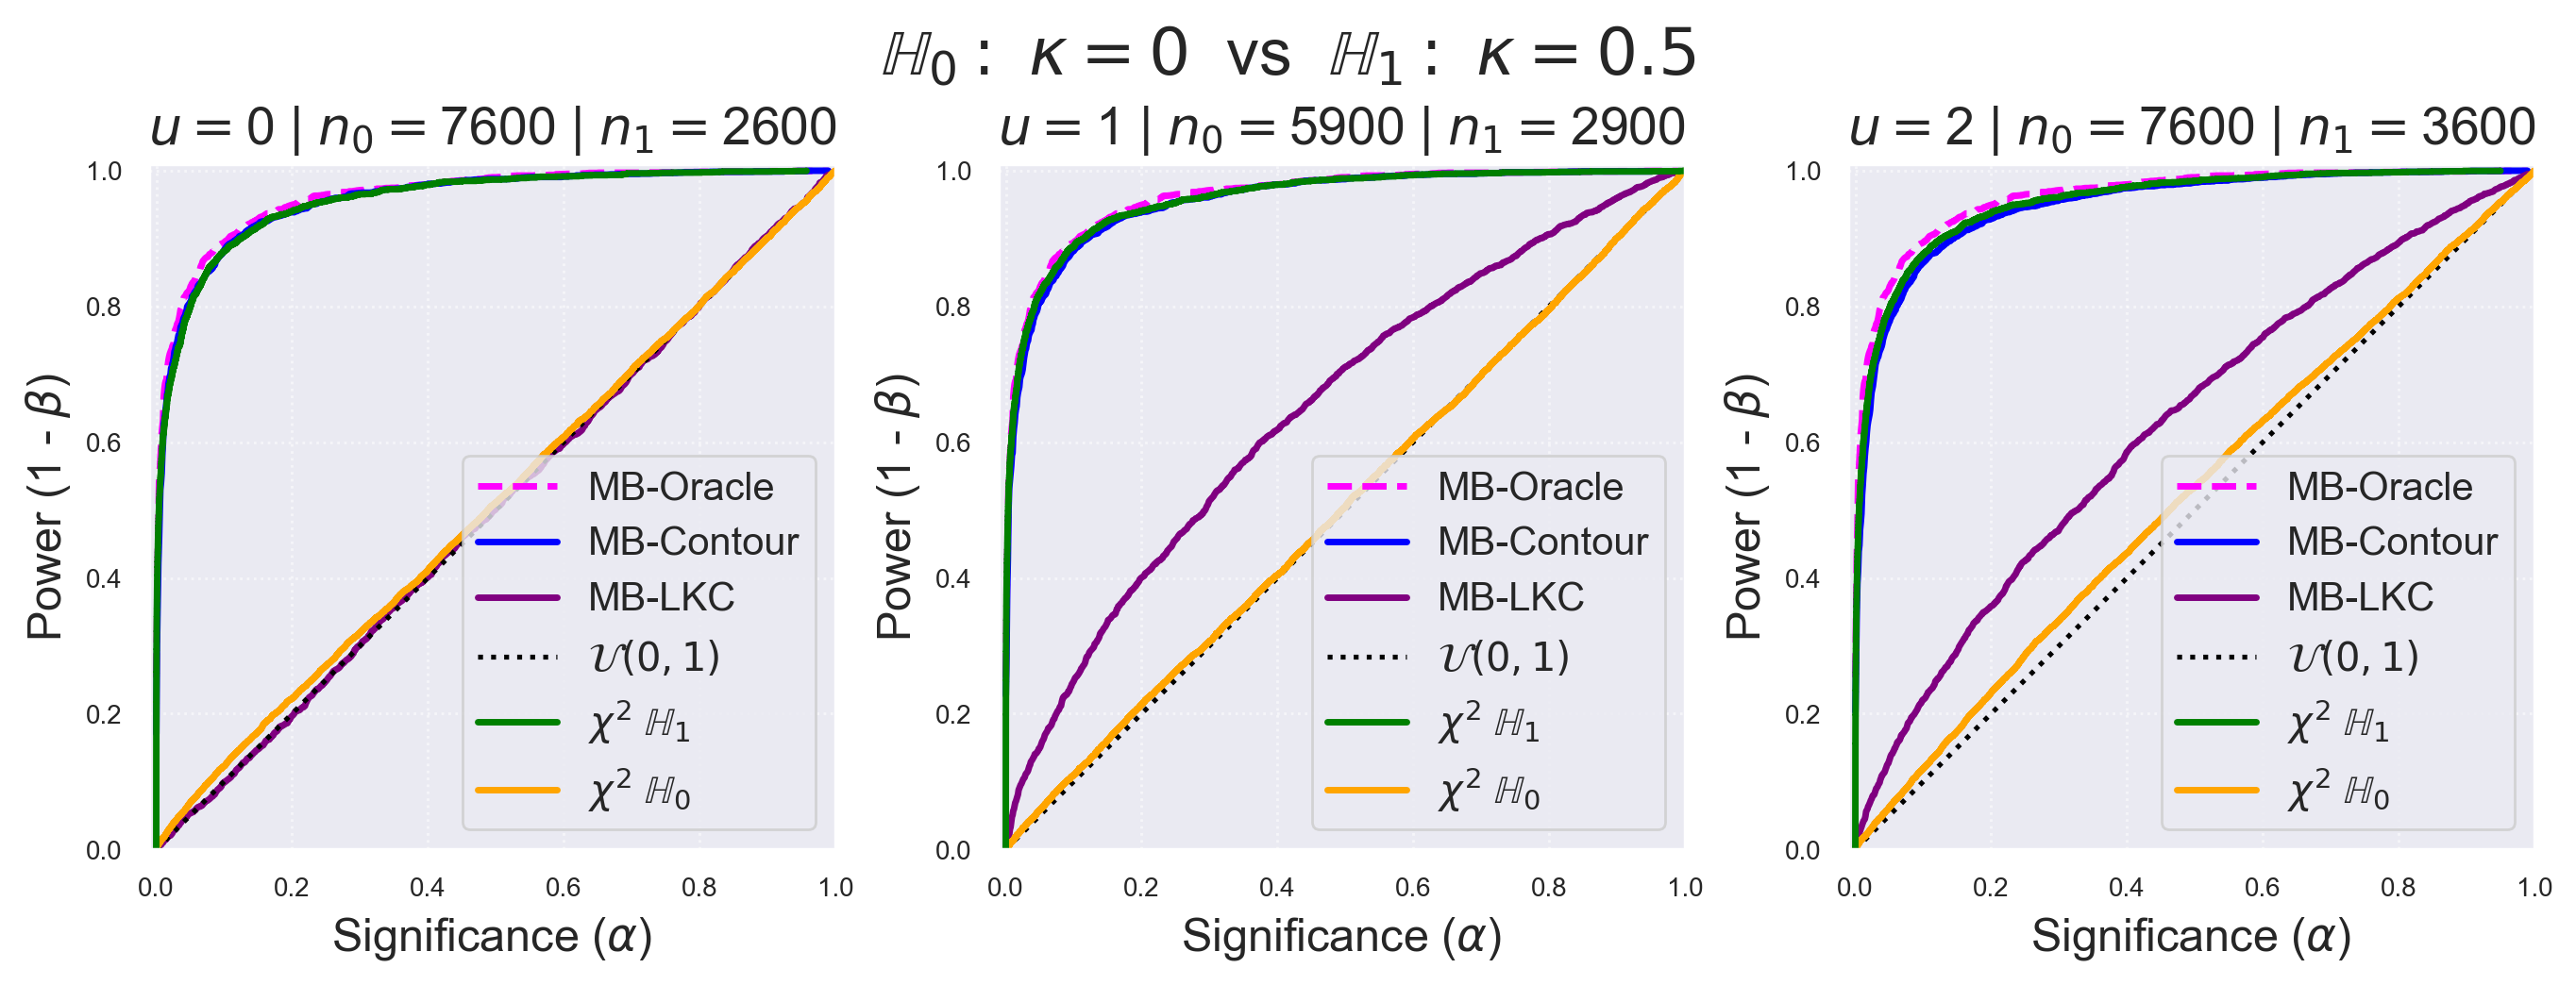

Terminé: génération des courbes de puissance.


In [13]:
# Paramètres principaux
filter_single_level = False
single_level_value = 0
kappa_alternative = 0.5
min_samples_for_percentile = 1
save_figs = False # True  # Sauvegarder les figures
output_prefix = "fig-powers"

# Debug option: toggle LaTeX in legend labels
use_latex_in_legends = True
if not use_latex_in_legends:
    print("Legend LaTeX disabled (debug mode)")

def legend_label(key: str) -> str:
    latex_map = {
        'uniform': '$\\mathcal{U}(0,1)$',
        'chi2_h0': '$\\chi^2$ $\\mathbb{H}_0$',
        'chi2_h1': '$\\chi^2$ $\\mathbb{H}_1$'
    }
    plain_map = {
        'uniform': 'U(0,1)',
        'chi2_h0': 'chi2 H0',
        'chi2_h1': 'chi2 H1'
    }
    table = latex_map if use_latex_in_legends else plain_map
    return table[key]

# Colonnes requises
required_columns = ['kappa', 'field_size', 'level_val', 'statistics_BD', 'empirical_cosine_cabana',
                    'empirical_sine_cabana', 'perimeter_cabana', 'T_parameter', 'chi2_pvalue', 'factor_divide', 'estimated_kappa_gradients']
missing_initial = [c for c in required_columns if c not in all_df.columns]
if missing_initial:
    print(f"Erreur: colonnes manquantes dans all_df: {missing_initial}")
else:
    # Filtrage optionnel du niveau
    work_df = all_df.copy()
    if filter_single_level:
        work_df = work_df[work_df['level_val'] == single_level_value]
        if work_df.empty:
            print(f"Aucune donnée après filtrage level_val == {single_level_value}.")
    
    df_h0_full = work_df[work_df['kappa'] == 0].copy()
    df_h1_full = work_df[work_df['kappa'] == kappa_alternative].copy()

    if df_h0_full.empty or df_h1_full.empty:
        print(f"Données insuffisantes: H0 (kappa=0) lignes={len(df_h0_full)}, H1 (kappa={kappa_alternative}) lignes={len(df_h1_full)}")
    else:
        common_t_params = sorted(list(set(df_h0_full['T_parameter'].unique()) & set(df_h1_full['T_parameter'].unique())))
        if not common_t_params:
            print(f"Aucun T_parameter commun entre kappa=0 et kappa={kappa_alternative}.")
        else:
            print(f"T communs: {common_t_params}")
            alphas = np.linspace(0.0001, 0.99, 1000)  # 200 suffisent pour lisibilité + vitesse

            # # Préférence LaTeX sûre
            # try:
            #plt.rcParams.update({'text.usetex': True, 'text.latex.preamble': r'\\usepackage{amsfonts}'})
            # except Exception:
            #     plt.rcParams.update({'text.usetex': False})

            fig_counter = 0
            for t_param in common_t_params:
                df_h0_t = df_h0_full[df_h0_full['T_parameter'] == t_param]
                df_h1_t = df_h1_full[df_h1_full['T_parameter'] == t_param]

                tp_col = 'total_points_generated'
                if tp_col in work_df.columns:
                    common_tp_values = sorted(list(set(df_h0_t[tp_col].unique()) & set(df_h1_t[tp_col].unique())))
                    if not common_tp_values:
                        common_tp_values = [None]
                else:
                    common_tp_values = [None]

                for tp_val in common_tp_values:
                    df_h0_tp_loop = df_h0_t
                    df_h1_tp_loop = df_h1_t
                    tp_title_suffix = ""
                    if tp_val is not None:
                        df_h0_tp_loop = df_h0_t[df_h0_t[tp_col] == tp_val]
                        df_h1_tp_loop = df_h1_t[df_h1_t[tp_col] == tp_val]
                        if df_h0_tp_loop.empty or df_h1_tp_loop.empty:
                            continue
                        tp_val_eng = f"{tp_val:.0e}" if tp_val >= 1e3 else str(int(tp_val))
                        tp_title_suffix = f", Pts Gen$=10^7$"

                    unique_field_sizes = sorted(list(set(df_h0_tp_loop['field_size'].unique()) & set(df_h1_tp_loop['field_size'].unique())))
                    unique_level_vals = sorted(list(set(df_h0_tp_loop['level_val'].unique()) & set(df_h1_tp_loop['level_val'].unique())))
                    if not unique_field_sizes or not unique_level_vals:
                        continue

                    nrows_plot = len(unique_field_sizes)
                    ncols_plot = len(unique_level_vals)

                    fig, axes = plt.subplots(nrows=nrows_plot, ncols=ncols_plot,
                                             figsize=(3.6 * ncols_plot, 3.6 * nrows_plot),
                                             squeeze=False, constrained_layout=True, dpi=250)
                    #$\\mathbb H_0:$ $\\kappa=0$ vs $\\mathbb{H}_1:$ $\\kappa=${kappa_alternative}
                    fig.suptitle('$\\mathbb{H}_0:\\ \\kappa=0$  vs  $\\mathbb{H}_1:\\ \\kappa=0.5$', fontsize=fontsize_suptitle, y=1.1)

                    for i_fs, fs_val in enumerate(unique_field_sizes):
                        for j_lvl, lvl_val in enumerate(unique_level_vals):
                            ax = axes[i_fs, j_lvl]

                            mask_h0 = (df_h0_tp_loop['field_size'] == fs_val) & (df_h0_tp_loop['level_val'] == lvl_val)
                            mask_h1 = (df_h1_tp_loop['field_size'] == fs_val) & (df_h1_tp_loop['level_val'] == lvl_val)
                            mask_h0_nolevel = (df_h0_tp_loop['field_size'] == fs_val) 
                            mask_h1_nolevel = (df_h1_tp_loop['field_size'] == fs_val)

                            # Extraction vecteurs
                            d0_cos = df_h0_tp_loop.loc[mask_h0, 'empirical_cosine_cabana'].dropna()
                            d1_cos = df_h1_tp_loop.loc[mask_h1, 'empirical_cosine_cabana'].dropna()
                            d0_sin = df_h0_tp_loop.loc[mask_h0, 'empirical_sine_cabana'].dropna()
                            d1_sin = df_h1_tp_loop.loc[mask_h1, 'empirical_sine_cabana'].dropna()
                            d0_per = df_h0_tp_loop.loc[mask_h0, 'perimeter_cabana'].dropna()
                            d1_per = df_h1_tp_loop.loc[mask_h1, 'perimeter_cabana'].dropna()
                            d0_bd = df_h0_tp_loop.loc[mask_h0, 'statistics_BD'].dropna()
                            d1_bd = df_h1_tp_loop.loc[mask_h1, 'statistics_BD'].dropna()
                            print(f"Debug: fs={fs_val}, lvl={lvl_val}, H0 n={len(d0_bd)}, H1 n={len(d1_bd)}")

                            # Construction statistiques Cabana (évite division par zéro)
                            if not d0_per.empty:
                                d0_cab = (d0_cos**2 + d0_sin**2) / np.maximum(d0_per, 1e-30)**2
                            else:
                                d0_cab = pd.Series(dtype=float)
                            if not d1_per.empty:
                                d1_cab = (d1_cos**2 + d1_sin**2) / np.maximum(d1_per, 1e-30)**2
                            else:
                                d1_cab = pd.Series(dtype=float)

                            ax.set_title(f'$u=${int(lvl_val)} | $n_0=${len(df_h0_tp_loop.loc[mask_h0, 'empirical_cosine_cabana'])} | $n_1=${len(df_h1_tp_loop.loc[mask_h1, 'empirical_cosine_cabana'])}', fontsize=fontsize_title)
                            ax.set_xlabel('Significance ($\\alpha$)', fontsize=fontsize_labels)
                            ax.set_ylabel('Power (1 - $\\beta$)', fontsize=fontsize_labels)
                            ax.tick_params(axis='both', labelsize=fontsize_ticks)
                            ax.grid(True, linestyle=':', alpha=0.55)
                            ax.set_xlim([-0.01, 1])
                            ax.set_ylim([0, 1.01])

                            if d0_cab.empty and d1_cab.empty and d0_bd.empty and d1_bd.empty:
                                ax.text(0.5, 0.5, 'Données insuffisantes', ha='center', va='center', transform=ax.transAxes, fontsize=7)
                                continue

                            power_cabana_vals = []
                            power_bd_vals = []
                            
                            # MB-Full-Grad (seuil haut, car estimateur de kappa)
                            d0_grad = df_h0_tp_loop.loc[mask_h0_nolevel, 'estimated_kappa_gradients'].dropna()
                            d1_grad = df_h1_tp_loop.loc[mask_h1_nolevel, 'estimated_kappa_gradients'].dropna()
                            
                            if len(d0_grad) >= min_samples_for_percentile and not d1_grad.empty:
                                q_grad = np.percentile(d0_grad, 100 * (1 - alphas))
                                arr1 = d1_grad.to_numpy()[:, None]
                                arrq = q_grad[None, :]
                                power_grad_vals = (arr1 > arrq).mean(axis=0)
                                ax.plot(alphas, power_grad_vals, color='magenta', label='MB-Oracle', linewidth=2, linestyle='--')

                            # Cabana (seuil haut -> grandes valeurs rejettent H0)
                            if len(d0_cab) >= min_samples_for_percentile and not d1_cab.empty:
                                q_cab = np.percentile(d0_cab, 100 * (1 - alphas))  # vecteur
                                # Broadcasting: d1_cab[:,None] > q_cab[None,:]
                                arr1 = d1_cab.to_numpy()[:, None]
                                arrq = q_cab[None, :]
                                power_cabana_vals = (arr1 > arrq).mean(axis=0)
                                ax.plot(alphas, power_cabana_vals, color='blue', label='MB-Contour', linewidth=2)
                            elif not d0_cab.empty or not d1_cab.empty:
                                ax.plot([], [], color='blue', label='MB-Contour (non tracé)', linewidth=2)

                            # BD (seuil bas -> petites valeurs rejettent H0)
                            if len(d0_bd) >= min_samples_for_percentile and not d1_bd.empty:
                                q_bd = np.percentile(d0_bd, 100 * alphas)
                                arr1b = d1_bd.to_numpy()[:, None]
                                arrqb = q_bd[None, :]
                                power_bd_vals = (arr1b < arrqb).mean(axis=0)
                                ax.plot(alphas, power_bd_vals, color='purple', label='MB-LKC', linewidth=2)
                            elif not d0_bd.empty or not d1_bd.empty:
                                ax.plot([], [], color='purple', label='MB-LKC (non tracé)')

                            # Courbe référence Uniforme pour p-values si pertinents
                            if len(d0_cab) >= min_samples_for_percentile or len(d0_bd) >= min_samples_for_percentile:
                                ax.plot([0,1],[0,1], color='black', linestyle=':', linewidth=1.5, label=legend_label('uniform'))

                            # P-values chi2 en ECDF (comparatives)
                            if 'chi2_pvalue' in df_h0_tp_loop.columns and 'chi2_pvalue' in df_h1_tp_loop.columns:
                                p_h0 = df_h0_tp_loop.loc[mask_h0, 'chi2_pvalue']#.dropna()
                                p_h1 = df_h1_tp_loop.loc[mask_h1, 'chi2_pvalue']#.dropna()
                                if not p_h0.empty:
                                    sns.ecdfplot(p_h0, ax=ax, color='orange', label=legend_label('chi2_h0'), linewidth=2)
                                if not p_h1.empty:
                                    sns.ecdfplot(p_h1, ax=ax, color='green', label=legend_label('chi2_h1'), linewidth=2)
                                    

                            handles, labels = ax.get_legend_handles_labels()
                            if handles:
                                # Ordre désiré
                                order_keys = ['MB-Oracle', 'MB-Contour', 'MB-LKC', legend_label('uniform'), legend_label('chi2_h1'), legend_label('chi2_h0')]
                                ordered = []
                                used = set()
                                for key in order_keys:
                                    for h,l in zip(handles, labels):
                                        if key in l and l not in used:
                                            ordered.append((h,l))
                                            used.add(l)
                                for h,l in zip(handles, labels):
                                    if l not in used:
                                        ordered.append((h,l))
                                ax.legend([h for h,_ in ordered],[l for _,l in ordered], fontsize=12, loc='best')
                            ax.set_aspect('equal', adjustable='box')

                    plt.show()
                    #if save_figs:
                    fig_counter += 1
                    fname = f"{output_prefix}_T{int(t_param)}_{fig_counter}.png"
                    #fig.savefig(fname, dpi=300, bbox_inches='tight')
                    #print(f"Figure sauvegardée: {fname}")
            print("Terminé: génération des courbes de puissance.")

In [14]:
# Export the analysis notebook to HTML for sharing outside Jupyter.
!jupyter nbconvert --to html --no-input --output="notebook_paper.html" visualisation_paper.ipynb

[NbConvertApp] WARNING | pattern 'visualisation_paper.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exe